# Анализ лояльности пользователей Яндекс Афиши

- Автор: Тайшин Илья
- Дата: 02/02/2026 ред. 15/02/2026

### Цели 
Выявить и описать ключевые характеристики и поведенческие паттерны пользователей, которые с наибольшей вероятностью совершают повторные заказы и возвращаются на платформу, на основе исследовательского анализа данных. Результаты позволят построить профиль перспективной аудитории, предложить рекомендации по персонализации коммуникаций и оптимизации маркетинговых бюджетов, а также повысить общий уровень удержания клиентов.

### Задачи проекта

1. Загрузить данные и познакомиться с их содержимым.
2. Провести предобработку данных.
3. Создать профиль пользователя
4. Провести исследовательский анализ данных:
    - Исследовать признаки первого заказа и их связи с возвращением на платформу
    - Исследовать поведение пользователей через показатели выручки и состава заказа
    - Исследовать временные характеристики первого заказа и их влияния на повторные покупки
    - Провести корреляционный анализ количества покупок и признаков пользователя
5. Сформировать выводы и дать рекомендации по проведенному анализу.  
6. Публикация на Git

### Описание данных
**Выгружаемый датафрейм содержит следующие данные:**

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.


### Содержимое проекта

1. [Загрузка данных и знакомство с их содержимым.](#chapter-1)
2. [Предобработка данных.](#chapter-2)
3. [Создание профиля пользователя](#chapter-3)
4. [Исследовательский анализ данных](#chapter-4)
5. [Выводы и рекомендации по проведенному анализу.](#chapter-5) 
6. [Публикация на Git](#chapter-6)
---

In [1]:
# Обновляю pip чтобы не вызывать ошибки. Загружаю нужные для работы библиотеки.
!pip3 install -q --upgrade pip
!pip3 install -q sqlalchemy psycopg2-binary seaborn phik pandas matplotlib
!pip3 install -q python-dotenv

# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем библиотеку для расчёта коэффициента корреляции phi_k
from phik import phik_matrix

# Импортирую библиотеку pandas
import pandas as pd
from sqlalchemy import create_engine

import numpy as np
import os
from dotenv import load_dotenv

    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^
    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^
    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^


In [2]:
load_dotenv() # автоматически ищет .env в текущей директории

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    os.getenv('DB_USER'),
    os.getenv('DB_PASSWORD'),
    os.getenv('DB_HOST'),
    os.getenv('DB_PORT'),
    os.getenv('DB_NAME'),
) 
engine = create_engine(connection_string)

In [3]:
#Загружаю подготовленный в SQL датафрейм
query = '''

WITH set_config_precode AS (
  SELECT set_config('synchronize_seqscans', 'off', true)
)
SELECT user_id,
       device_type_canonical,
       order_id,
       created_dt_msk AS order_dt,
       created_ts_msk AS order_ts,
       currency_code,
       revenue,
       tickets_count, 
       DATE_PART('day', created_dt_msk - LAG(created_dt_msk) OVER (PARTITION BY user_id ORDER BY created_dt_msk))::integer AS days_since_prev,
       p.event_id,
       service_name,
       e.event_type_main, 
       r.region_name,
       city_name
FROM afisha.purchases as p
left join afisha.events e on p.event_id = e.event_id
left join afisha.city c on e.city_id = c.city_id
left join afisha.regions r on c.region_id = r.region_id 
WHERE device_type_canonical IN ('mobile', 'desktop') AND e.event_type_main != 'фильм'
ORDER BY user_id ASC;

'''

In [4]:
#Создаю датафрейм и присваиваю ему имя df 
df = pd.read_sql_query(query, con=engine)

In [5]:
#Проверяю выгрузку. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  service_name           290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  region_name            290611 non-null  obje

In [6]:
initial_total = len(df)
print(f"Исходный размер датафрейма: {initial_total} строк")

Исходный размер датафрейма: 290611 строк


In [7]:
#Вывожу первые строки датафрейма
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,Край билетов,театр,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,Мой билет,выставки,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,За билетом!,другое,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,Лови билет!,другое,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,Билеты без проблем,стендап,Озернинский край,Родниковецк


---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [8]:
#Создаю копию датасета для возможности проверить внесенные изменения. 
temp = df.copy() 
len(temp)

290611

In [9]:
#Проверяю что можно привести к категориальному типу данных.
print(df['event_type_main'].unique())
print(df['service_name'].unique())
print(df['device_type_canonical'].unique())
print(df['currency_code'].unique())

['театр' 'выставки' 'другое' 'стендап' 'концерты' 'спорт' 'ёлки']
['Край билетов' 'Мой билет' 'За билетом!' 'Лови билет!'
 'Билеты без проблем' 'Облачко' 'Лучшие билеты' 'Прачечная' 'Быстробилет'
 'Дом культуры' 'Весь в билетах' 'Билеты в руки' 'Тебе билет!'
 'Show_ticket' 'Городской дом культуры' 'Яблоко' 'Билет по телефону'
 'Выступления.ру' 'Росбилет' 'Шоу начинается!' 'Мир касс' 'Восьмёрка'
 'Телебилет' 'Crazy ticket!' 'Реестр' 'Быстрый кассир' 'КарандашРУ'
 'Радио ticket' 'Дырокол' 'Вперёд!' 'Кино билет' 'Цвет и билет' 'Зе Бест!'
 'Тех билет' 'Лимоны' 'Билеты в интернете']
['mobile' 'desktop']
['rub' 'kzt']


In [10]:
#Проверяем какие данные представлены в ценах. 
stats_by_revenue = df.groupby('currency_code')['revenue'].agg(['min', 'max', 'mean', 'median', 'count'])
print(stats_by_revenue)

                 min       max         mean   median   count
currency_code                                               
kzt             0.00  26425.86  4995.206767  3698.83    5069
rub           -90.76  81174.54   548.013929   346.63  285542


In [11]:
#Проверяем какие данные представлены в количестве купленных билетов. 
stats_by_tickets = df.groupby('currency_code')['tickets_count'].agg(['min', 'max', 'mean', 'median'])
print(stats_by_tickets)

               min  max      mean  median
currency_code                            
kzt              1    6  2.762872       3
rub              1   57  2.754159       3


  **Датасет** содержит `14` столбцов и `290 611` строк, в которых представлена информация о пользователях и их покупок билетов на различные мероприятия. Также представлена техническая информация о покупках: `где был куплен билет`, `дата и время покупки`, `с какого типа устройства куплен билет`. 
  Исходя из первичного анализ данных можно сделать следующие выводы:
  - Названия столбцов соответствуют формату `snake_case`.
  - В столбце `days_since_prev` содержатся пропуски. Скорей всего образовались на первых заказах пользователей. =
  - Можно сократить размерность типов данных.
  - Столбец `event_type_main`, `currency_code` и `device_type_canonical` можно перевести в категориальный.
  - Столбец `service_name`, `region_name` и `city_name` можно привести к формату snake_case для исключения неявных дубликатов. 
  - В датасете представлена разная валюта, следовательно можно привести все к единой валюте, например `rub`
  - Задействовано `31.0+ МБ` оперативной памяти. 
  - В столбце `revenue` присутствуют отрицательные значения.
  
 По результатам выгрузки данных планиурется сделать: проверить категориальные столбцы на предмет неявных дубликатов,привести выручку к единой валюте, убедиться, что пропуски действительно имеются только у первых заказов, выполнить проверку на дубликаты (явные и неявные).

---

###  2. Предобработка данных <a name="chapter-2"></a>
Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [12]:
#Загружаю датасет с курсом Тенге в 2024г
df_course_tenge_2024 = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [13]:
#Вывожу информацию по датасету.
df_course_tenge_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


In [14]:
#Выгружаю первые строки датасета.
df_course_tenge_2024.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [15]:
df_course_tenge_2024.tail()

,data,nominal,curs,cdx
352,2024-12-27,100,19.2705,kzt
353,2024-12-28,100,19.5105,kzt
354,2024-12-29,100,19.4860,kzt
355,2024-12-30,100,19.4860,kzt
356,2024-12-31,100,19.4860,kzt


В `2024` году было `366` дней. В датасете представлено `357` дней. Данные начинаются с `10/01/2024`. Данные за **первые `9 дней 2024 года` отсутствуют**.

Так как датасет представлен по дням мы можем сопоставить цену билета в конкретный день с ее курсом в этот день.
Также стоит проверить наличие покупок билетов в период с `01/01` по `09/01` включительно, чтобы понять есть ли у нас все необходимые данные. 

In [16]:
filtered_data = df.query(
    "order_dt >= '2024-01-01' and order_dt <= '2024-01-09' and currency_code == 'kzt'"
)
# Проверка наличия записей
print(f"Количество найденных записей: {len(filtered_data)}")

Количество найденных записей: 0


Билетов купленных в тенге в период `01/01` по `09/01` включительно нет. Следовательно нам достаточно данных для конвертации. 
Теперь для рассчета конвертаций в столбец `revenue_rub` будет определна следующая логика: 
 - Приводим даты к единому типу данных.
 - Если валюта `kzt` то делим на 100 и умножаем на курс. 
 - Если валюта `rub` то перезаписываем данные. 

In [17]:
# Привожу тип данных с объекта в дату для датафреймов
df_course_tenge_2024['data'] = pd.to_datetime(df_course_tenge_2024['data'])

# Создаю столбец с курсом за 1 тенге
df_course_tenge_2024['rate_per_one'] = df_course_tenge_2024['curs'] / 100

# Присоединяю к основному датафрейму два столбца с датой и курсом за 1 тенге
merged = pd.merge(
    df,
    df_course_tenge_2024[['data', 'rate_per_one']],
    left_on='order_dt',
    right_on='data',
    how='left'
)

# Функция которая конвертирует валюту 
def convert_revenue(row):
    if row['currency_code'] == 'rub':
        return row['revenue']
    elif row['currency_code'] == 'kzt' and pd.notna(row['rate_per_one']):
        return row['revenue'] * row['rate_per_one']
    elif row['currency_code'] == 'kzt' and pd.isna(row['rate_per_one']):
        print(f"Для даты {row['order_dt']} не найден курс валют!")
        return None
    else: 
        print(f"Неизвестная валюта: {row['currency_code']}")
        return None

# Применяем к каждой строке
df['revenue_rub'] = merged.apply(convert_revenue, axis=1)

# Убираем временные колонки
df = df.drop(columns=['data', 'rate_per_one'], errors='ignore')

#Проверяем  
stats_by_revenue_rub = df.groupby('currency_code')['revenue_rub'].agg(['min', 'max', 'mean', 'median','count'])

stats_by_revenue_rub


,min,max,mean,median,count
currency_code,,,,,
kzt,0.00,5256.843478,981.325159,734.654217,5069
rub,-90.76,81174.540000,548.013929,346.630000,285542


In [18]:
#Сравниваем 
stats_by_revenue

,min,max,mean,median,count
currency_code,,,,,
kzt,0.00,26425.86,4995.206767,3698.83,5069
rub,-90.76,81174.54,548.013929,346.63,285542


Столбец добавил, валюту конвертировал перехожу к предобработке данных.

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  service_name           290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  region_name            290611 non-null  obje

In [20]:
# Сохраняем исходный размер для отслеживания изменений
initial_len = len(df)
print(f"Исходный размер датафрейма: {initial_len} строк")

# Явные дубликаты (полное совпадение всех столбцов, кроме order_id и days_since_prev)
cols_for_dupes = [col for col in df.columns if col not in ['order_id', 'days_since_prev']]
dupes = df.duplicated(subset=cols_for_dupes, keep=False)
print(f"Найдено явных дубликатов (без учёта order_id и days_since_prev): {dupes.sum()}")

if dupes.sum() > 0:
    print("Примеры дубликатов (первые 5):")
    display(df[dupes].sort_values(by=['user_id', 'order_dt']).head(5))
    
    # Удаляем дубликаты (оставляем первое вхождение)
    df = df.drop_duplicates(subset=cols_for_dupes, keep='first')
    print(f"После удаления дубликатов осталось строк: {len(df)}")
    print(f"Удалено: {initial_len - len(df)} строк ({(initial_len - len(df))/initial_len*100:.2f}%)")
    # Обновляем initial_len после удаления дубликатов
    initial_len = len(df)
else:
    print("Явных дубликатов не обнаружено.")

Исходный размер датафрейма: 290611 строк
Найдено явных дубликатов (без учёта order_id и days_since_prev): 77
Примеры дубликатов (первые 5):


,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,region_name,city_name,revenue_rub
11759,06eb7897f65b433,mobile,1123867,2024-08-13,2024-08-13 16:31:07,rub,69.82,1,0.0,183706,Билеты в руки,театр,Светополянский округ,Глиноград,69.82
11760,06eb7897f65b433,mobile,1123983,2024-08-13,2024-08-13 16:31:07,rub,69.82,1,0.0,183706,Билеты в руки,театр,Светополянский округ,Глиноград,69.82
26868,0dc525d7bacbb0d,desktop,1930705,2024-07-31,2024-07-31 13:26:11,rub,1556.05,3,11.0,393430,Лови билет!,концерты,Каменевский регион,Глиногорск,1556.05
26870,0dc525d7bacbb0d,desktop,1930763,2024-07-31,2024-07-31 13:26:11,rub,1556.05,3,0.0,393430,Лови билет!,концерты,Каменевский регион,Глиногорск,1556.05
53680,206ea45ec11d478,mobile,1935171,2024-10-29,2024-10-29 16:46:54,rub,601.69,2,32.0,442183,Билеты в руки,концерты,Каменевский регион,Глиногорск,601.69


После удаления дубликатов осталось строк: 290571
Удалено: 40 строк (0.01%)


In [21]:
print(f"После удаления явных дубликатов осталось: {len(df)} строк")
print(f"Всего удалено на этом этапе: {initial_total - len(df)} ({(initial_total - len(df))/initial_total*100:.2f}%)")

После удаления явных дубликатов осталось: 290571 строк
Всего удалено на этом этапе: 40 (0.01%)


In [22]:
# Проверяю георграфию на странности
def check_rare_values(column, threshold=10):
    counts = df[column].value_counts()
    rare = counts[counts < threshold].index.tolist()
    print(f"\nСтолбец '{column}': всего уникальных {len(counts)}, редких (<{threshold}) {len(rare)}")
    if rare:
        print(f"Примеры редких значений (первые 10): {rare[:10]}")

# Проверяем географию и сервисы
for col in ['city_name', 'region_name', 'service_name']:
    check_rare_values(col)



Столбец 'city_name': всего уникальных 352, редких (<10) 112
Примеры редких значений (первые 10): ['Верховка', 'Реченск', 'Бережанск', 'Зелёново', 'Шынартас', 'Речинск', 'Заречка', 'Нежинск', 'Серебринск', 'Сарыбулак']

Столбец 'region_name': всего уникальных 81, редких (<10) 1
Примеры редких значений (первые 10): ['Теплоозёрский округ']

Столбец 'service_name': всего уникальных 36, редких (<10) 3
Примеры редких значений (первые 10): ['Лимоны', 'Зе Бест!', 'Билеты в интернете']


Видим в столбце 'city_name' неявный дубликат `РечИнск` и `РечЕнск`. Приводим их к единому формату. 

In [23]:
# Устраняем неявные дубликаты в city_name
city_replacements = {"Реченск": "Речинск"}
df['city_name'] = df['city_name'].replace(city_replacements)

# Проверяем результат
print("После объединения дубликатов:")
check_rare_values('city_name')

После объединения дубликатов:

Столбец 'city_name': всего уникальных 351, редких (<10) 110
Примеры редких значений (первые 10): ['Заречка', 'Серебринск', 'Бережанск', 'Шынартас', 'Нежинск', 'Верховка', 'Зелёново', 'Родничанск', 'Лесодолинск', 'Златоречье']


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290571 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290571 non-null  object        
 1   device_type_canonical  290571 non-null  object        
 2   order_id               290571 non-null  int64         
 3   order_dt               290571 non-null  datetime64[ns]
 4   order_ts               290571 non-null  datetime64[ns]
 5   currency_code          290571 non-null  object        
 6   revenue                290571 non-null  float64       
 7   tickets_count          290571 non-null  int64         
 8   days_since_prev        268638 non-null  float64       
 9   event_id               290571 non-null  int64         
 10  service_name           290571 non-null  object        
 11  event_type_main        290571 non-null  object        
 12  region_name            290571 non-null  obje

In [25]:
# мы удаляли дубликаты, интервалы между заказами для некоторых пользователей могли измениться.
# Пересчитываем days_since_prev для всех пользователей заново.

if 'user_id' in df.columns and 'order_dt' in df.columns:
    # Сортируем по пользователю и дате заказа
    df = df.sort_values(['user_id', 'order_dt'])
    # Рассчитываем разницу в днях между последовательными заказами для каждого пользователя
    df['days_since_prev'] = df.groupby('user_id')['order_dt'].diff().dt.days
    print("Столбец days_since_prev пересчитан.")
else:
    print("Не найдены колонки user_id или order_dt для пересчёта.")
#переводим в Int    
df['days_since_prev'] = df['days_since_prev'].astype('Int64')

Столбец days_since_prev пересчитан.


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290571 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290571 non-null  object        
 1   device_type_canonical  290571 non-null  object        
 2   order_id               290571 non-null  int64         
 3   order_dt               290571 non-null  datetime64[ns]
 4   order_ts               290571 non-null  datetime64[ns]
 5   currency_code          290571 non-null  object        
 6   revenue                290571 non-null  float64       
 7   tickets_count          290571 non-null  int64         
 8   days_since_prev        268638 non-null  Int64         
 9   event_id               290571 non-null  int64         
 10  service_name           290571 non-null  object        
 11  event_type_main        290571 non-null  object        
 12  region_name            290571 non-null  obje

In [27]:
def show_missing_stats(tmp0):
    missing_stats = pd.DataFrame({
        'Кол-во пропусков': tmp0.isnull().sum(),
        'Доля пропусков': tmp0.isnull().mean()
    })
    missing_stats = missing_stats[missing_stats['Кол-во пропусков'] > 0]
    
    if missing_stats.empty:
        return "Пропусков в данных нет"
    
    # Форматируем при выводе через Styler
    return (missing_stats.style.format({'Доля пропусков': '{:.4f}'}).background_gradient(cmap='coolwarm'))

show_missing_stats(df)

,Кол-во пропусков,Доля пропусков
days_since_prev,21933,0.0755


Доля пропусков в столбце `days_since_prev` составляет `7,55%`. Это значительный объем данных. Так как первично мы извлекали данные с условием, что пользователи с одной покупкой имеют значение NaN. Мы можем сказать о том, что `7,55%` пользователей совершали всего одну покупку билетов в 2024 году. 

In [28]:
# Проверка гипотезы
missing_hours = df[df['days_since_prev'].isnull()]

missing_hours.nunique()

user_id                  21933
device_type_canonical        2
order_id                 21933
order_dt                   153
order_ts                 21910
currency_code                2
revenue                  11516
tickets_count               13
days_since_prev              0
event_id                  7663
service_name                34
event_type_main              7
region_name                 81
city_name                  258
revenue_rub              11834
dtype: int64

Действительно `21 933` уникальных пользователя совершили всего `1` покупку. 

Проверяем показатели в категориальных данные. 
К ним могут относятся: `device_type_canonical`, `currency_code`, `service_name`, `event_type_main`

In [29]:
print(df['device_type_canonical'].nunique())
print(df['currency_code'].nunique())
print(df['service_name'].nunique())
print(df['event_type_main'].nunique())

2
2
36
7


`service_nam` это можно не относить к категориальым данным с номинальными данными так как там содержится слишком много значений. Мы уже привели все к формату `snake_case` для этого столбца.

In [30]:
print(df['device_type_canonical'].unique())
print(df['currency_code'].unique())
print(df['event_type_main'].unique())

['mobile' 'desktop']
['rub' 'kzt']
['театр' 'выставки' 'другое' 'стендап' 'концерты' 'спорт' 'ёлки']


`device_type_canonical` содержит название типа устройства с которого совершалась покупка. Пропусков нет. Данные соответствуют.
`currency_code` содержит название валюты в которой происходила оплата. Пропусков нет. Данные соответствуют. 
`event_type_main` содержит в себе категорию мероприятия на которую был куплен билет. Мы видем что присутствует категоря `другое`. Это может означать, что либо были пропуски в данных и их заменили на конкретную категорию `другое`, либо кол-во покупок в других категориях слишком мало, чтобы объеденить их в отдельную категория, следовательно была создана категоря `другое`. 

In [31]:
#Проверим распределение купленных билетов по категориям 
stats_by_category = df.groupby('event_type_main')['tickets_count'].agg(['min', 'max', 'mean', 'median','sum','count'])
stats_by_category_sorted = stats_by_category.sort_values(by='sum', ascending=False)
stats_by_category_sorted

,min,max,mean,median,sum,count
event_type_main,,,,,,
концерты,1,12,2.656082,3,306156,115266
театр,1,19,2.759683,3,185757,67311
другое,1,57,2.769699,3,182393,65853
спорт,1,47,3.053182,3,66883,21906
стендап,1,6,2.992309,3,40076,13393
выставки,1,6,2.556563,3,12407,4853
ёлки,1,8,3.344897,3,6653,1989


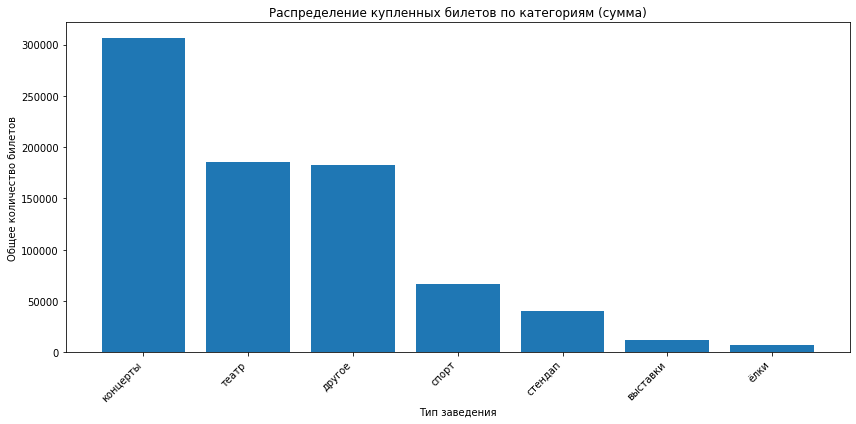

In [32]:
plt.figure(figsize=(12, 6))
plt.bar(stats_by_category_sorted.index, stats_by_category_sorted['sum'])
plt.title('Распределение купленных билетов по категориям (сумма)')
plt.xlabel('Тип заведения')
plt.ylabel('Общее количество билетов')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Исходя из анализа распределения, можно предположить, что категория `другое` либо: 
- имело большую долю пропусков, что привело к решению о создании такой категории.
- было принято решение не создавать много разных категорий и объеденить вторичные в одну большую.

In [33]:
# Вывожу сводку по столбцу 
df['revenue_rub'].describe()

count    290571.000000
mean        555.585977
std         875.528775
min         -90.760000
25%         113.970000
50%         351.140000
75%         802.050000
max       81174.540000
Name: revenue_rub, dtype: float64

Данные показывают сильную асимметрию: средний чек `555.57` значительно превышает медиану `351.14`, что указывает на правостороннее распределение с большим количеством мелких заказов и редкими крупными. Высокое стандартное отклонение `875.50` подтверждает значительную вариативность данных. Присутствуют аномальные значения: отрицательная выручка `-90.76` и экстремальный максимум `81,174.54`, который в значительно превышает медиану и указывает на наличие выбросов. Следует проанализировать отрицательные значения и избавиться от выбросов. 

In [34]:
negative_rows = df[df['revenue_rub'] < 0]
negative_rows.sort_values(by='revenue_rub').head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,region_name,city_name,revenue_rub
226266,c02e67523e534d6,mobile,1740146,2024-10-29,2024-10-29 18:58:02,rub,-90.76,5,0,570411,Билеты в руки,спорт,Медовская область,Радужсвет,-90.76
85647,3ee7dc2e115847f,mobile,1599206,2024-09-19,2024-09-19 09:07:24,rub,-17.94,5,0,568916,Билеты в руки,другое,Малиновая область,Зеленополье,-17.94
288827,fe237d2cfd6e503,mobile,6804329,2024-10-11,2024-10-11 10:49:27,rub,-10.77,3,0,568916,Билеты в руки,другое,Малиновая область,Зеленополье,-10.77
227532,c1c7641fd348ed1,mobile,521537,2024-10-24,2024-10-24 09:04:00,rub,-10.77,3,0,568916,Билеты в руки,другое,Малиновая область,Зеленополье,-10.77
119844,586f795f132bf46,mobile,2489419,2024-09-26,2024-09-26 09:41:31,rub,-10.77,3,0,568916,Билеты в руки,другое,Малиновая область,Зеленополье,-10.77


In [35]:
#Относительное и абсолютное значение строк с отрицательной выручкой. 
print(len(negative_rows))
len(negative_rows)/len(df)*100

381


0.13112113734681025

interval columns not set, guessing: ['event_id', 'revenue_rub']
Корреляционная матрица с коэффициентом phi_k для переменной с отрицательной выручкой


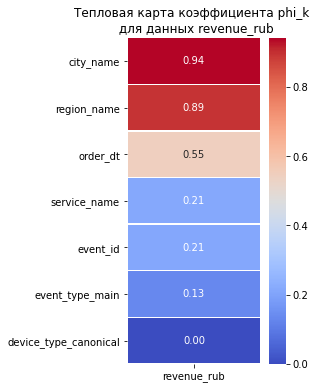

In [36]:
# проверим взаимосвязь с другими столбцами.
# Вычисляем корреляционную матрицу с использованием phi_k
correlation_matrix = negative_rows[['order_dt','city_name','region_name','service_name','event_id','event_type_main', 'device_type_canonical', 'revenue_rub']].phik_matrix()

# Выводим результат
print('Корреляционная матрица с коэффициентом phi_k для переменной с отрицательной выручкой')
correlation_matrix.loc[correlation_matrix.index != 'revenue_rub'][['revenue_rub']].sort_values(by='revenue_rub', ascending=False)



plt.figure(figsize=(3, 6))
data_heatmap = correlation_matrix.loc[correlation_matrix.index != 'revenue_rub'][['revenue_rub']].sort_values(by='revenue_rub', ascending=False)
sns.heatmap(data_heatmap,
            annot=True, # Отображаем численные значения в ячейках карты
            fmt='.2f', # Форматируем значения корреляции: два знака после точки
            cmap='coolwarm', # Устанавливаем цветовую гамму от красного (макс. значение) к синему
            linewidths=0.5,# Форматируем линию между ячейками карты
            cbar=True # Отключаем цветовую шкалу
           )

# Добавляем заголовок и подпись по оси Х
plt.title('Тепловая карта коэффициента phi_k \n для данных revenue_rub')


# Выводим график
plt.show()

In [37]:
stats_by_region = negative_rows.groupby('region_name')['revenue_rub'].agg(['min', 'max', 'mean', 'median','sum','count'])
stats_by_region_sorted = stats_by_region.sort_values(by='count', ascending=False)
stats_by_region_sorted

,min,max,mean,median,sum,count
region_name,,,,,,
Берёзовская область,-6.16,-0.22,-2.042358,-1.960,-216.49,106
Широковская область,-2.45,-0.08,-0.685429,-0.270,-47.98,70
Солнечноземская область,-4.15,-1.38,-2.662500,-2.770,-106.50,40
Малиновая область,-17.94,-3.59,-6.381944,-5.385,-229.75,36
Речицкий регион,-4.81,-1.60,-3.139200,-3.200,-78.48,25
Зоринский регион,-6.33,-0.09,-1.749444,-0.430,-31.49,18
Светополянский округ,-2.23,-0.10,-0.893333,-0.760,-13.40,15
Североярская область,-8.53,-0.21,-1.738571,-0.620,-24.34,14
Дальнеземская область,-6.18,-0.14,-2.323077,-2.010,-30.20,13


Итого мы видим, что в данных присутствуют `381` отрицательно значение, что составляет `0,13%` от всей выборки данных. Проверяем с чем они могут быть связаны и наблюдаем наибольшую корреляцию с регионом, городом и датой. Вероятно отрицательные значения связаны с большим количеством возвратом или отмен мероприятий, либо техническими ошибками в этих регионах. Мы не можем это проверить, по этому **принято решение не учитывать их в анализе.** 

In [38]:
# Убираем строки, где revenue_rub < 0 и переходим работать в датафрейм после фильтрации. 
df_clean = df[df['revenue_rub'] >= 0].copy()

print(f"Исходный размер: {len(df):,} строк")
print(f"После очистки: {len(df_clean):,} строк")
print(f"Удалено: {len(df) - len(df_clean):,} строк")
print(f"Процент удаленных: {(len(df) - len(df_clean))/len(df)*100:.4f}%")

Исходный размер: 290,571 строк
После очистки: 290,190 строк
Удалено: 381 строк
Процент удаленных: 0.1311%


In [39]:
# Вывожу сводку по столбцу 
df_clean['revenue_rub'].describe()

count    290190.000000
mean        556.318697
std         875.869615
min           0.000000
25%         114.610000
50%         352.080000
75%         802.250000
max       81174.540000
Name: revenue_rub, dtype: float64

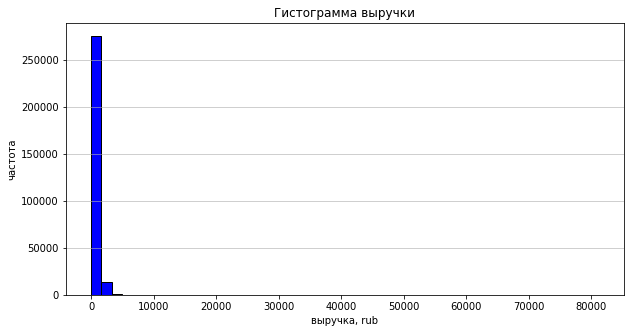

In [40]:
# Гистограмма
plt.figure(figsize=(10, 5))
plt.hist(df_clean['revenue_rub'], bins=50, color='blue', edgecolor='black')
plt.title('Гистограмма выручки')
plt.xlabel('выручка, rub')
plt.ylabel('частота')
plt.grid(axis='y', alpha=0.75)
plt.show()

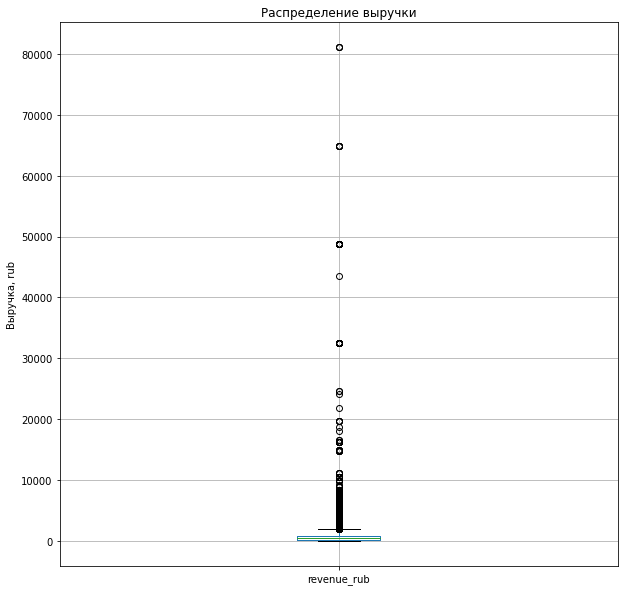

In [41]:
df.boxplot(column='revenue_rub', figsize=(10, 10))
plt.title('Распределение выручки')
plt.ylabel('Выручка, rub')
plt.show()

Исходя из графиков видно наличие выбрасов. Это может сказаться на общем анализе данных так как цель нашего исследования вывявить характеристики типового клиента. Большие разовые заказы не относятся к поведению типового клиента. Принято решение отфильтровать значение по 99 перцентилю. 

In [42]:
#Анализирую выбросы
q99 = df_clean['revenue_rub'].quantile(0.99)
hight_rows = df_clean[df_clean['revenue_rub'] > q99]
hight_rows.sort_values(by='revenue_rub').head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,region_name,city_name,revenue_rub
160692,8187dac4be757a0,mobile,1151011,2024-10-06,2024-10-06 12:58:52,rub,2628.63,4,0,567030,Весь в билетах,ёлки,Каменевский регион,Глиногорск,2628.63
280144,f7ceefdcf6fd89e,mobile,3862482,2024-10-09,2024-10-09 21:57:08,rub,2629.08,4,52,541673,Весь в билетах,концерты,Каменевский регион,Глиногорск,2629.08
130029,64db1506a4854aa,desktop,6108532,2024-06-18,2024-06-18 23:25:01,rub,2633.19,5,2,266741,Билеты без проблем,концерты,Каменевский регион,Глиногорск,2633.19
148081,7b25a521d1d47fb,desktop,2425097,2024-07-12,2024-07-12 14:48:28,rub,2633.19,5,0,266741,Билеты без проблем,концерты,Каменевский регион,Глиногорск,2633.19
261518,e5103f87766763e,mobile,7996983,2024-08-09,2024-08-09 18:36:35,rub,2633.21,3,0,553371,Лови билет!,театр,Каменевский регион,Глиногорск,2633.21


In [43]:
# Убираем строки выше 99 перцентиля
df_clean = df_clean[df_clean['revenue_rub'] <= q99]

print(f"Исходный размер: {len(df):,} строк")
print(f"После очистки: {len(df_clean):,} строк")
print(f"Удалено: {len(df) - len(df_clean):,} строк")
print(f"Процент удаленных: {(len(df) - len(df_clean))/len(df)*100:.4f}%")

Исходный размер: 290,571 строк
После очистки: 287,365 строк
Удалено: 3,206 строк
Процент удаленных: 1.1033%


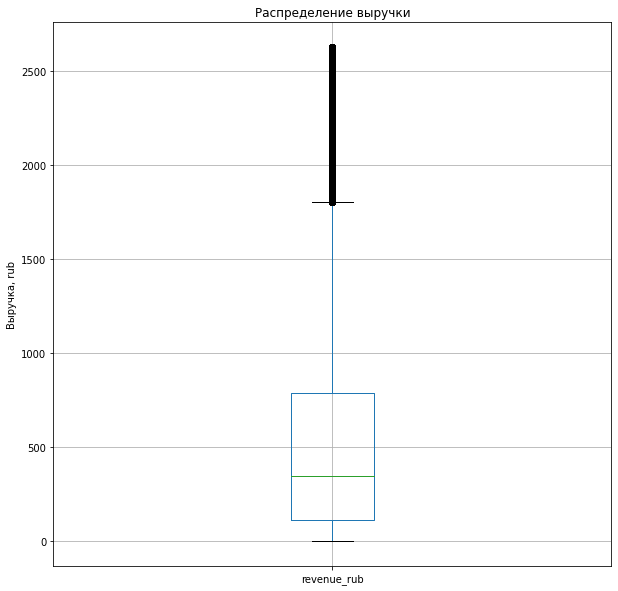

In [44]:
df_clean.boxplot(column='revenue_rub', figsize=(10, 10))
plt.title('Распределение выручки')
plt.ylabel('Выручка, rub')
plt.show()

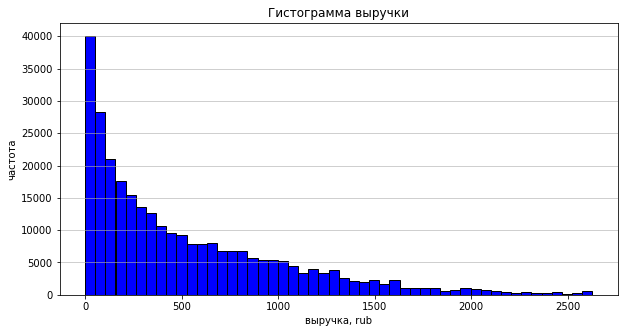

In [45]:
# Гистограмма
plt.figure(figsize=(10, 5))
plt.hist(df_clean['revenue_rub'], bins=50, color='blue', edgecolor='black')
plt.title('Гистограмма выручки')
plt.xlabel('выручка, rub')
plt.ylabel('частота')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [46]:
# Вывожу сводку по столбцу 
df_clean['revenue_rub'].describe()

count    287365.000000
mean        518.728274
std         511.937024
min           0.000000
25%         112.640000
50%         344.840000
75%         788.900000
max        2628.421739
Name: revenue_rub, dtype: float64

Итого было выявлено `2825` выбросов, по условиям было принято решение их исключить из анализа. После исключения можно сделать следующие выводы: Очистка данных дала значительные улучшения. После удаления отрицательных значений и фильтрации по `99` перцентилю данные стали значительно чище и стабильнее. Средний чек снизился с `555.57` до `517.38` рублей, а медиана с `351.14` до `344.30` рублей, что указывает на уменьшение влияния выбросов. Наиболее заметное изменение — резкое падение стандартного отклонения с `875.50` до `509.35` рублей, что свидетельствует о существенном снижении вариативности данных. Максимальное значение сократилось катастрофически — с `81,174.54` до всего `2,627` рублей, что подтверждает эффективность фильтрации экстремальных выбросов. 

In [47]:
#Перехожу к анализу проданых билетов. 
df_clean['tickets_count'].describe()

count    287365.000000
mean          2.741329
std           1.163065
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max          57.000000
Name: tickets_count, dtype: float64

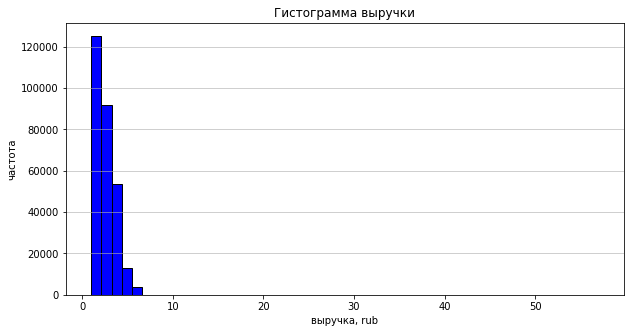

In [48]:
# Гистограмма
plt.figure(figsize=(10, 5))
plt.hist(df_clean['tickets_count'], bins=50, color='blue', edgecolor='black')
plt.title('Гистограмма выручки')
plt.xlabel('выручка, rub')
plt.ylabel('частота')
plt.grid(axis='y', alpha=0.75)
plt.show()

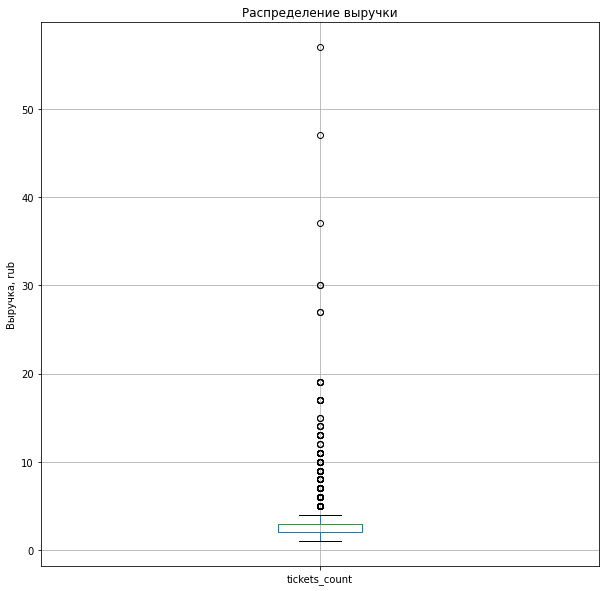

In [49]:
df_clean.boxplot(column='tickets_count', figsize=(10, 10))
plt.title('Распределение выручки')
plt.ylabel('Выручка, rub')
plt.show()

In [50]:
#Анализирую выбросы
t99 = df_clean['tickets_count'].quantile(0.99)
hight_rows_ticket = df_clean[df_clean['tickets_count'] > t99]
hight_rows_ticket.sort_values(by='tickets_count').head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,region_name,city_name,revenue_rub
289366,fe237d2cfd6e503,mobile,6425879,2024-10-31,2024-10-31 19:22:09,rub,497.85,7,0,586659,Мой билет,другое,Североярская область,Озёрск,497.85
247567,d4f86a2e47f76dc,desktop,3696747,2024-09-20,2024-09-20 10:24:43,rub,675.06,7,0,524924,Мой билет,другое,Каменевский регион,Глиногорск,675.06
132727,68b0fbd811fe024,mobile,8291420,2024-08-24,2024-08-24 00:58:07,rub,907.54,7,<NA>,419794,Билеты без проблем,другое,Североярская область,Озёрск,907.54
131783,67d2f1ea3a71af2,mobile,4288463,2024-06-24,2024-06-24 16:08:30,rub,884.56,7,0,519212,Билеты без проблем,другое,Североярская область,Озёрск,884.56
131782,67d2f1ea3a71af2,mobile,4288434,2024-06-24,2024-06-24 15:47:18,rub,884.56,7,0,519212,Билеты без проблем,другое,Североярская область,Озёрск,884.56


In [51]:
# Оптимизируем типы данных в датафрейме
df_clean['revenue'] = pd.to_numeric(df_clean['revenue'], downcast='integer')
df_clean['revenue_rub'] = pd.to_numeric(df_clean['revenue_rub'], downcast='integer')

for column in ['order_id','tickets_count','event_id']:
    df_clean[column] = pd.to_numeric(df_clean[column],downcast='integer')
df_clean['device_type_canonical'] = df_clean['device_type_canonical'].astype('category')
df_clean['currency_code'] = df_clean['currency_code'].astype('category')
df_clean['event_type_main'] = df_clean['event_type_main'].astype('category')   
    
#приводим данные к формату snake_case
def to_snake_case(value):
    return str(value).replace(' ', '_').lower()


df_clean[['service_name', 'region_name','city_name']] = df_clean[['service_name', 'region_name','city_name']].applymap(to_snake_case)

In [52]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287365 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                287365 non-null  object        
 1   device_type_canonical  287365 non-null  category      
 2   order_id               287365 non-null  int32         
 3   order_dt               287365 non-null  datetime64[ns]
 4   order_ts               287365 non-null  datetime64[ns]
 5   currency_code          287365 non-null  category      
 6   revenue                287365 non-null  float64       
 7   tickets_count          287365 non-null  int8          
 8   days_since_prev        265665 non-null  Int64         
 9   event_id               287365 non-null  int32         
 10  service_name           287365 non-null  object        
 11  event_type_main        287365 non-null  category      
 12  region_name            287365 non-null  obje

In [53]:
total_removed = initial_total - len(df_clean)
print(f"Итого удалено строк: {total_removed} ({total_removed/initial_total*100:.2f}%)")

Итого удалено строк: 3246 (1.12%)


На основе анализа данных выборки из `287 365` наблюдений среднее значение показателя составляет около `2.74` при стандартном отклонении `1.16`, что указывает на относительно низкую вариативность данных вокруг среднего. Распределение является правосторонне асимметричным, о чём свидетельствует существенная разница между медианой (3.0) и средним `2.74`, а также наличие экстремальных выбросов вплоть до максимального значения `57`, значительно превышающего `75-й перцентиль`, равный `3`. При этом `50%` центральных значений лежат в узком интервале от `2` до `3`, что подтверждает высокую концентрацию данных около медианы.

Количество выбросов `~180`, что относительно не много и относится к разовым покупкам на группу людей.

**Итого** пропущенные значения обнаружены только в столбце `days_since_prev (7,55%)`, что соответствует ожиданиям — эти значения характеризуют пользователей с единственной покупкой. Типы данных были скорректированы, даты приведены к единому формату, числовые данные оптимизированы для экономии памяти (освобождено более `7,8 МБ`).

Категориальные данные проанализированы и нормализованы: значения приведены к `snake_case`, проверены на наличие обозначений пропусков. Обнаружена категория `"другое"` в `event_type_main`, что может свидетельствовать либо об исходных пропусках, либо о стратегии агрегации редких категорий.


Ключевые метрики — выручка (revenue_rub) и количество билетов (tickets_count) обработаны аномалии: удалены `381` отрицательный заказ (`0,13%` данных) и отфильтрованы выбросы по `99` перцентилю (`2,825` записей). В результате:

Распределение revenue_rub стало более сбалансированным: средний чек снизился с `555.57` до `517.38` руб, стандартное отклонение уменьшилось с `875.50` до `509.35` руб, максимум сократился с `81,174.54` до `2,627` руб.

Данные `tickets_count` содержат незначительно кол-во выбросов которые относятся к разовым покупкам билетов на группу людей. Было принято решение оставить данные в выборке. 

Общий объем данных сократился незначительно: из `290,611` строк удалено `3,246 (1.12%)`. Очищенный датасет сохранил репрезентативность (`98.98%` исходных данных)

---

### 3. Создание профиля пользователя <a name="chapter-3"></a>

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [54]:
#Сортирую данные по дате и времени совершения заказа.
df_clean_sort = df_clean.sort_values(by='order_ts', ascending=False)

#Группирую данные по пользователям
user_profile = df_clean_sort.groupby('user_id').agg(
    first_dt=('order_ts','first'),
    last_dt=('order_ts','last'),
    first_device=('device_type_canonical', 'first'),
    first_region=('region_name','first'),
    first_service=('service_name','first'),
    first_genre=('event_type_main','first'),
    total_orders=('order_id', 'count'),
    avg_revenue=('revenue', 'mean'),
    avg_ticket_count=('tickets_count', 'mean'),
    avg_days_since_prev=('days_since_prev','mean')
).reset_index()

#добавляю is_two и is_five 
user_profile['is_two'] = (user_profile['total_orders'] >= 2)
user_profile['is_five'] = (user_profile['total_orders'] >= 5)

user_profile.head()

,user_id,first_dt,last_dt,first_device,first_region,first_service,first_genre,total_orders,avg_revenue,avg_ticket_count,avg_days_since_prev,is_two,is_five
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,mobile,каменевский_регион,край_билетов,театр,1,1521.940000,4.000000,<NA>,False,False
1,0005ca5e93f2cf4,2024-10-06 13:56:02,2024-07-23 18:36:24,mobile,каменевский_регион,за_билетом!,другое,2,774.010000,3.000000,75.0,True,False
2,000898990054619,2024-10-23 15:12:00,2024-07-13 19:40:48,mobile,лугоградская_область,облачко,концерты,3,767.213333,2.666667,51.0,True,False
3,00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,desktop,каменевский_регион,край_билетов,театр,1,917.830000,4.000000,<NA>,False,False
4,000a55a418c128c,2024-10-15 10:29:04,2024-09-29 19:39:12,mobile,поленовский_край,лучшие_билеты,театр,2,61.310000,1.500000,16.0,True,False


In [55]:
#Абсолютное и относительно значение пропусков. 
show_missing_stats(user_profile)

,Кол-во пропусков,Доля пропусков
avg_days_since_prev,8333,0.3816


In [56]:
#Количество клиентов совершивших 2-а и более заказа 
def show_count_stats(data, column_name):
    counts = data[column_name].value_counts().sort_index()
    shares = data[column_name].value_counts(normalize=True).sort_index()
    
    count_stats = pd.DataFrame({
        'Кол-во клиентов': counts,
        'Доля клиентов': shares
    })
    
    return (count_stats.style.format({'Доля клиентов': '{:.4f}'})
                           .background_gradient(cmap='coolwarm'))

# Количестов клиентов совершивших 2 и более заказа. 
show_count_stats(user_profile, 'is_two')

,Кол-во клиентов,Доля клиентов
False,8363,0.3830
True,13475,0.6170


In [57]:
#Количество клиентов совершивших 5 и более заказа 
show_count_stats(user_profile, 'is_five')


,Кол-во клиентов,Доля клиентов
False,15508,0.7101
True,6330,0.2899


In [58]:
user_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21838 entries, 0 to 21837
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              21838 non-null  object        
 1   first_dt             21838 non-null  datetime64[ns]
 2   last_dt              21838 non-null  datetime64[ns]
 3   first_device         21838 non-null  object        
 4   first_region         21838 non-null  object        
 5   first_service        21838 non-null  object        
 6   first_genre          21838 non-null  object        
 7   total_orders         21838 non-null  int64         
 8   avg_revenue          21838 non-null  float64       
 9   avg_ticket_count     21838 non-null  float64       
 10  avg_days_since_prev  13505 non-null  Float64       
 11  is_two               21838 non-null  bool          
 12  is_five              21838 non-null  bool          
dtypes: Float64(1), bool(2), datetim

Профиль содержит данные `21 838` уникальных пользователей. У всех пользователей есть данные о первом и последнем заказе, регионе, сервисе и жанре первого мероприятия. Среднее время между заказами доступно только для `13 505` пользователей `62%`, что означает, что `38%` пользователей совершили лишь один заказ.

Количество пользователей которые совершиил покупку `2-а` и более раза составило `61%`, а `5` и более `29%`.
Это говорит о том, что типовой клиент имеет высокую долю возвращаемости в сервис.

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [59]:
#Вывожу информацию о профилях пользователей
total_users = len(user_profile)
avg_revenue_per_order = user_profile['avg_revenue'].mean()
share_two_plus = user_profile['is_two'].mean()
share_five_plus = user_profile['is_five'].mean()

print(f"Общее число пользователей: {total_users}")
print(f"Средняя выручка с одного заказа: {avg_revenue_per_order:.2f} руб.")
print(f"Доля пользователей с 2+ заказами: {share_two_plus:.2%}")
print(f"Доля пользователей с 5+ заказами: {share_five_plus:.2%}")

Общее число пользователей: 21838
Средняя выручка с одного заказа: 633.98 руб.
Доля пользователей с 2+ заказами: 61.70%
Доля пользователей с 5+ заказами: 28.99%


In [60]:
user_profile['total_orders'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99])

count    21838.000000
mean        13.158943
std        121.564858
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
90%         15.000000
95%         31.000000
96%         41.000000
97%         54.000000
98%         79.000000
99%        152.000000
max      10168.000000
Name: total_orders, dtype: float64

Распределение количества заказов на пользователя характеризуется высокой правосторонней асимметрией: 75% пользователей совершили 5 или менее заказов (медиана равна 2), однако среднее значение в 13.2 заказа сильно завышено из-за экстремальных выбросов. Данные необходимо отфильтровать по 99 перцентилю для корректного описания типового пользователя. 

Для профиля типового клиента используйте данные, отфильтрованные по 99-му перцентилю (≤152 заказов). Это оптимальный баланс между очисткой от аномалий и сохранением репрезентативности выборки.

In [61]:
#Вывожу статистику по столбцу
user_profile['avg_ticket_count'].describe()

count    21838.000000
mean         2.744063
std          0.913068
min          1.000000
25%          2.000000
50%          2.750000
75%          3.080000
max         11.000000
Name: avg_ticket_count, dtype: float64

Распределение среднего количества билетов на заказ является значительно более сбалансированным по сравнению с количеством заказов: среднее значение `2.74` близко к медиане `2.75`, а стандартное отклонение `0.91` относительно невелико, что указывает на низкую вариативность данных. `75%` пользователей приобретают в среднем до `3.08` билета за раз, а максимальное значение `11` билетов хотя и является выбросом, но не носит экстремального характера и может соответствовать реальным групповым покупкам; таким образом, фильтрация данных по этому признаку не требуется.

In [62]:
#Вывожу статистику по столбцу
user_profile['avg_days_since_prev'].describe()

count    13505.000000
mean        15.863847
std         22.322464
min          0.000000
25%          1.000000
50%          8.000000
75%         20.500000
max        148.000000
Name: avg_days_since_prev, dtype: float64

Распределение среднего времени между заказами показывает умеренную правостороннюю асимметрию: медиана составляет `8` дней, в то время как среднее значение почти в два раза выше `15.86 дней`, что указывает на наличие пользователей с очень редкими повторными покупками. При этом `75%` пользователей возвращаются в течение `21` дня, а максимальный интервал в `148` дней является статистически высоким, но всё же реалистичным значением, отражающим долгосрочное клиентское поведение. Фильтрация не требуется. 

In [63]:
# Убираем строки выше 99-го перцентиля по столбцу 'total_orders'
to99 = user_profile['total_orders'].quantile(0.99)
user_profile_clear = user_profile[user_profile['total_orders'] <= to99]

print(f"Исходный размер: {len(user_profile):,} строк")
print(f"После очистки: {len(user_profile_clear):,} строк")
print(f"Удалено: {len(user_profile) - len(user_profile_clear):,} строк")
print(f"Процент удаленных: {(len(user_profile) - len(user_profile_clear))/len(user_profile)*100:.4f}%")

Исходный размер: 21,838 строк
После очистки: 21,622 строк
Удалено: 216 строк
Процент удаленных: 0.9891%


In [64]:
#Вывожу статистику по столбцу
user_profile_clear['total_orders'].describe()

count    21622.000000
mean         6.495653
std         14.308424
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        152.000000
Name: total_orders, dtype: float64

In [65]:
total_users_clear = len(user_profile_clear)
avg_revenue_per_order_clear = user_profile_clear['avg_revenue'].mean()
share_two_plus_clear = user_profile_clear['is_two'].mean()
share_five_plus_clear = user_profile_clear['is_five'].mean()


#Вывожу информацию после фильтрации. 
print(f"Общее число пользователей: {total_users_clear}")
print(f"Средняя выручка с одного заказа: {avg_revenue_per_order_clear:.2f} руб.")
print(f"Доля пользователей с 2+ заказами: {share_two_plus_clear:.2%}")
print(f"Доля пользователей с 5+ заказами: {share_five_plus_clear:.2%}")

Общее число пользователей: 21622
Средняя выручка с одного заказа: 634.78 руб.
Доля пользователей с 2+ заказами: 61.32%
Доля пользователей с 5+ заказами: 28.28%


После фильтрации данных по `99-му` перцентилю (≤152 заказа) распределение количества заказов на пользователя стало значительно более сбалансированным: среднее значение снизилось с `13.2` до `6.5` заказов, приблизившись к медиане (2 заказа), а стандартное отклонение уменьшилось с `121.6` до `14.3`, что свидетельствует о существенном снижении вариативности. Теперь `75%` пользователей совершают до `5` заказов, а максимальное значение в `152` заказа, хотя и остаётся высоким, является статистически обоснованной верхней границей для типичных клиентов, что делает выборку репрезентативной для построения профиля массового пользователя.

Общее кол-во пользователей составило `21622` (было `21838`)
Средняя выручка с одного заказа: `634.78 руб.` (было `633,98 руб`)
Доля пользователей с 2+ заказами: `61.32%` (было `61,70%`)
Доля пользователей с 5+ заказами: `28.28%` (было `28,99%`) 

---

### 4. Исследовательский анализ данных <a name="chapter-4"></a>

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [66]:
#группирую пользователей по типу первого мероприятия 
genre_stats = (user_profile_clear.groupby('first_genre')
               .agg(users_count=('user_id', 'count'))
               .assign(share=lambda x: x['users_count'] / len(user_profile_clear))
               .sort_values('users_count', ascending=False))
genre_stats

,users_count,share
first_genre,,
концерты,9200,0.425493
другое,5123,0.236935
театр,4564,0.211081
стендап,1054,0.048747
спорт,1038,0.048007
выставки,438,0.020257
ёлки,205,0.009481


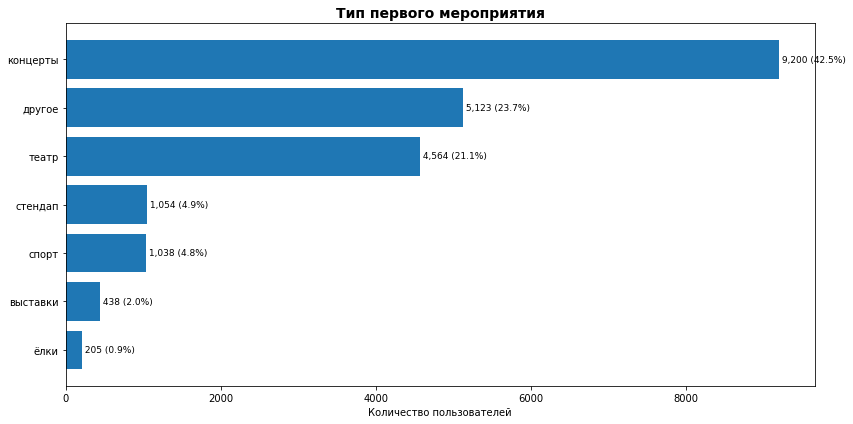

In [67]:
# 1. График для типа первого мероприятия 
plt.figure(figsize=(12, 6))
bars = plt.barh(genre_stats.index[::-1], genre_stats['users_count'][::-1])
plt.xlabel('Количество пользователей')
plt.title('Тип первого мероприятия', fontsize=14, fontweight='bold')

# Добавляем подписи с долями
for i, (value, share) in enumerate(zip(genre_stats['users_count'][::-1], genre_stats['share'][::-1])):
    plt.text(value, i, f' {value:,} ({share:.1%})', va='center', fontsize=9)

plt.tight_layout()
plt.show()

Распределение неравномерно! 3 основных жанра (концерты `42.5%`, другое `23.7%`, театр `21.1%`) охватывают `87%` всех пользователей, что указывает на высокий спрос типового пользователя. Можно сделать вывод, что для привлечения новых клиентов следует делать акцент в маркетингке на рекламу и акции этих направлений.

In [68]:
#группирую пользователей по типу первого устройства 
device_stats = (user_profile_clear.groupby('first_device')
               .agg(users_count=('user_id', 'count'))
               .assign(share=lambda x: x['users_count'] / len(user_profile_clear))
               .sort_values('users_count', ascending=False))
device_stats

,users_count,share
first_device,,
mobile,17916,0.8286
desktop,3706,0.1714


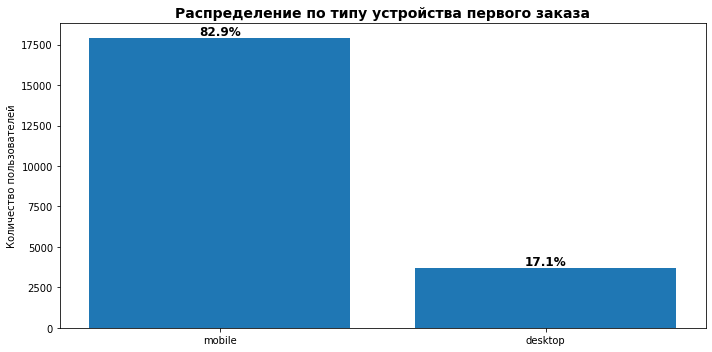

In [69]:
# 2. График для типа устройства
plt.figure(figsize=(10, 5))
bars = plt.bar(device_stats.index, device_stats['users_count'])
plt.ylabel('Количество пользователей')
plt.title('Распределение по типу устройства первого заказа', fontsize=14, fontweight='bold')

# Добавляем подписи
for i, (value, share) in enumerate(zip(device_stats['users_count'], device_stats['share'])):
    plt.text(i, value, f'{share:.1%}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Мобильные устройства доминируют с долей `82.9%`, что составляет подавляющее большинство первого взаимодействия с сервисом, демонстрируя мобильный тренд. Следует изучить детальнее распределение на операционную систему, чтобы корректно настроить контекстную рекламу для привлечения новых клиентов и увеличения частоты покупки текущих. 

In [70]:
#группирую пользователей по региону проведения мероприятия первого заказа
region_stats = (user_profile_clear.groupby('first_region')
               .agg(users_count=('user_id', 'count'))
               .assign(share=lambda x: x['users_count'] / len(user_profile_clear))
               .sort_values('users_count', ascending=False))
region_stats

,users_count,share
first_region,,
каменевский_регион,6918,0.319952
североярская_область,3357,0.155259
широковская_область,1146,0.053002
озернинский_край,837,0.038711
малиновоярский_округ,577,0.026686
...,...,...
верхозёрский_край,1,0.000046
верховинская_область,1,0.000046
светолесский_край,1,0.000046


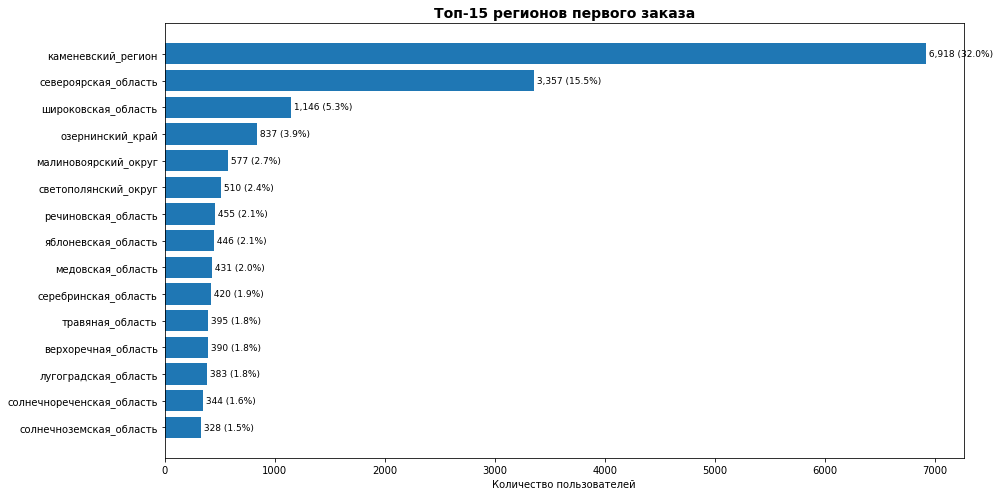

In [71]:
# 3. График для регионов (топ-15)
plt.figure(figsize=(14, 7))
top_regions = region_stats.head(15)
bars = plt.barh(top_regions.index[::-1], top_regions['users_count'][::-1])
plt.xlabel('Количество пользователей')
plt.title('Топ-15 регионов первого заказа', fontsize=14, fontweight='bold')

# Добавляем подписи
for i, (value, share) in enumerate(zip(top_regions['users_count'][::-1], top_regions['share'][::-1])):
    plt.text(value, i, f' {value:,} ({share:.1%})', va='center', fontsize=9)

plt.tight_layout()
plt.show()

Каменевский регион `32.0%` и Североярская область `15.5%` составляют почти половину всех пользователей, при этом `81` регион имеет незначительную долю, что указывает на локальную специфику сервиса. Это может быть связано с плотностью населения в этих регионов. 

In [72]:
#группирую пользователей по первому сервису покупки билета на мероприятие
service_stats = (user_profile_clear.groupby('first_service')
               .agg(users_count=('user_id', 'count'))
               .assign(share=lambda x: x['users_count'] / len(user_profile_clear))
               .sort_values('users_count', ascending=False))
service_stats

,users_count,share
first_service,,
билеты_без_проблем,4806,0.222274
мой_билет,2979,0.137776
лови_билет!,2967,0.137221
билеты_в_руки,2414,0.111646
облачко,2193,0.101424
лучшие_билеты,1384,0.064009
весь_в_билетах,1260,0.058274
прачечная,598,0.027657
яблоко,409,0.018916


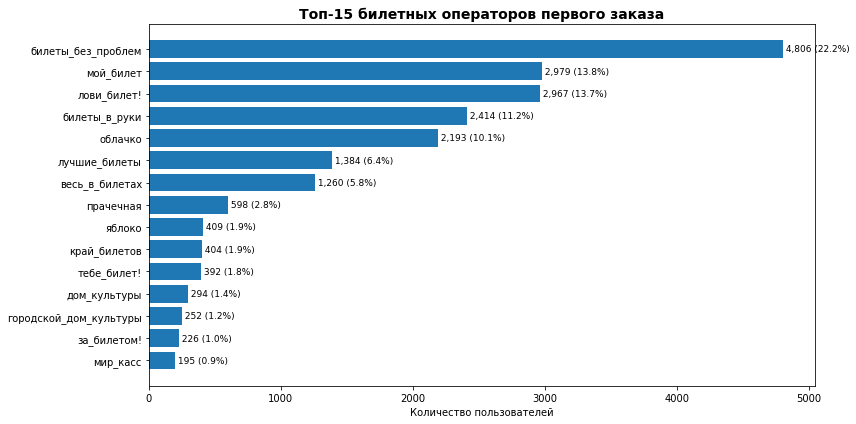

In [73]:
# 4. График для билетных операторов (топ-15)
plt.figure(figsize=(12, 6))
top_services = service_stats.head(15)
bars = plt.barh(top_services.index[::-1], top_services['users_count'][::-1])
plt.xlabel('Количество пользователей')
plt.title('Топ-15 билетных операторов первого заказа', fontsize=14, fontweight='bold')

# Добавляем подписи
for i, (value, share) in enumerate(zip(top_services['users_count'][::-1], top_services['share'][::-1])):
    plt.text(value, i, f' {value:,} ({share:.1%})', va='center', fontsize=9)

plt.tight_layout()
plt.show()

Топ-5 операторов охватывают `~71%` пользователей, но ни один не доминирует абсолютно (лидер "билеты_без_проблем" - `22.2%`), что свидетельствует о конкурентной среде без явного монополиста. 



**ВЫВОД**
Анализ воронки первых заказов выявил выраженную неравномерность распределения пользователей по всем ключевым сегментам, что формирует четкие `"точки входа"` в сервис. Типичный пользователь впервые обращается к платформе преимущественно с мобильного устройства `82.9%` для покупки билетов на концерты `42.5%` в Каменевском регионе `32.0%` через оператора "билеты_без_проблем" `22.2%`. Три основных культурных направления (концерты, "другое", театр) концентрируют `87%` спроса, указывая на устойчивые потребительские предпочтения.



---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [74]:
# 1. Для типа первого мероприятия
genre_retention = (user_profile_clear.groupby('first_genre')
                   .agg(
                       total_users=('user_id', 'count'),
                       users_with_2plus=('is_two', 'sum'),
                       users_with_5plus=('is_five', 'sum')
                   )
                   .assign(
                       retention_2plus=lambda x: x['users_with_2plus'] / x['total_users'],
                       retention_5plus=lambda x: x['users_with_5plus'] / x['total_users']
                   )
                   .sort_values('total_users', ascending=False))
genre_retention

,total_users,users_with_2plus,users_with_5plus,retention_2plus,retention_5plus
first_genre,,,,,
концерты,9200,5548,2500,0.603043,0.271739
другое,5123,2939,1360,0.573687,0.265469
театр,4564,3012,1400,0.659947,0.306748
стендап,1054,620,258,0.588235,0.244782
спорт,1038,687,370,0.661850,0.356455
выставки,438,290,133,0.662100,0.303653
ёлки,205,163,93,0.795122,0.453659


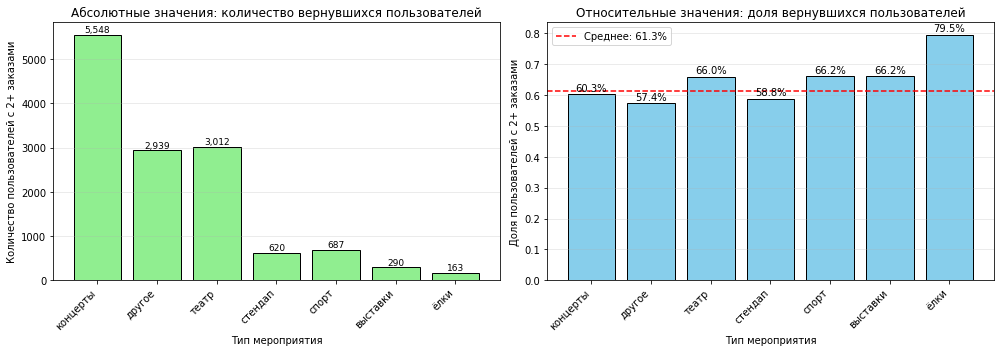

In [75]:
# Создаем фигуру с двумя графиками
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Данные
x = np.arange(len(genre_retention))
absolute_values = genre_retention['users_with_2plus']
relative_values = genre_retention['retention_2plus']
avg_retention = user_profile_clear['is_two'].mean()

# 1. АБСОЛЮТНЫЙ 
bars1 = ax1.bar(x, absolute_values, color='lightgreen', edgecolor='black')
ax1.set_xlabel('Тип мероприятия')
ax1.set_ylabel('Количество пользователей с 2+ заказами')
ax1.set_title('Абсолютные значения: количество вернувшихся пользователей')
ax1.set_xticks(x)
ax1.set_xticklabels(genre_retention.index, rotation=45, ha='right')
ax1.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for i, count in enumerate(absolute_values):
    ax1.text(i, count + max(absolute_values)*0.01, f'{count:,}', 
             ha='center', fontsize=9)

# ОТНОСИТЕЛЬНЫЙ 
bars2 = ax2.bar(x, relative_values, color='skyblue', edgecolor='black')
ax2.set_xlabel('Тип мероприятия')
ax2.set_ylabel('Доля пользователей с 2+ заказами')
ax2.set_title('Относительные значения: доля вернувшихся пользователей')
ax2.set_xticks(x)
ax2.set_xticklabels(genre_retention.index, rotation=45, ha='right')

# Линия среднего ретеншена
ax2.axhline(y=avg_retention, color='red', linestyle='--', 
            label=f'Среднее: {avg_retention:.1%}')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for i, rate in enumerate(relative_values):
    ax2.text(i, rate + 0.01, f'{rate:.1%}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

Распределение `retention` по жанрам неравномерно: сегмент `"ёлки"` демонстрирует исключительно высокий показатель `79,5%`, однако его малый объём в `205` пользователей делает эту оценку статистически незначимой. Среди массовых жанров выделяются `"театр"` и `"спорт"` с `retention` около `66%`, в то время как самый популярный жанр `"концерты"` показывает средний уровень `60,3%`. Это указывает на то, что тип первого мероприятия влияет на дальнейшую лояльность, но не является однозначным индикаором.

In [76]:
device_retention = (user_profile_clear.groupby('first_device')
                    .agg(
                        total_users=('user_id', 'count'),
                        users_with_2plus=('is_two', 'sum'),
                        users_with_5plus=('is_five', 'sum')
                    )
                    .assign(
                        retention_2plus=lambda x: x['users_with_2plus'] / x['total_users'],
                        retention_5plus=lambda x: x['users_with_5plus'] / x['total_users']
                    )
                    .sort_values('total_users', ascending=False))
device_retention

,total_users,users_with_2plus,users_with_5plus,retention_2plus,retention_5plus
first_device,,,,,
mobile,17916,10897,4999,0.608227,0.279024
desktop,3706,2362,1115,0.637345,0.300863


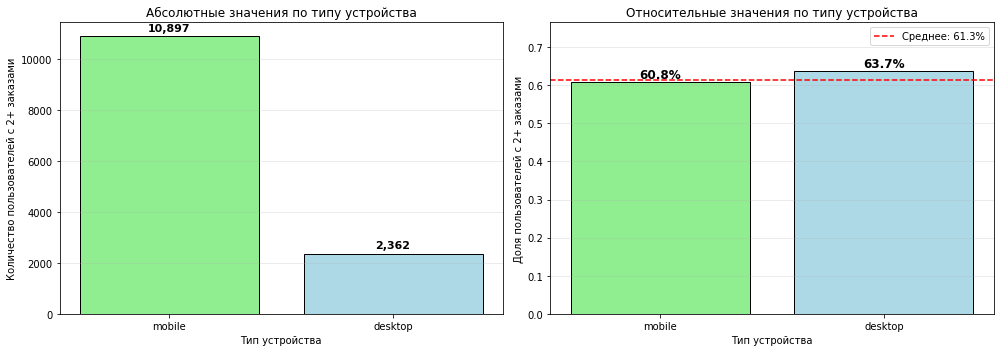

In [77]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Абсолютный 
bars1_abs = ax1.bar(device_retention.index, device_retention['users_with_2plus'], 
                    color=['lightgreen', 'lightblue'], edgecolor='black')
ax1.set_xlabel('Тип устройства')
ax1.set_ylabel('Количество пользователей с 2+ заказами')
ax1.set_title('Абсолютные значения по типу устройства')
ax1.grid(True, alpha=0.3, axis='y')

# Добавляем значения на абсолютный график
for i, count in enumerate(device_retention['users_with_2plus']):
    ax1.text(i, count + max(device_retention['users_with_2plus'])*0.02, 
             f'{count:,}', ha='center', fontsize=11, fontweight='bold')

# Относительный 
bars2_rel = ax2.bar(device_retention.index, device_retention['retention_2plus'], 
                    color=['lightgreen', 'lightblue'], edgecolor='black')
ax2.set_xlabel('Тип устройства')
ax2.set_ylabel('Доля пользователей с 2+ заказами')
ax2.set_title('Относительные значения по типу устройства')
ax2.set_ylim(0, max(device_retention['retention_2plus']) * 1.2)

# Линия среднего
avg_retention = user_profile_clear['is_two'].mean()
ax2.axhline(y=avg_retention, color='red', linestyle='--', 
            label=f'Среднее: {avg_retention:.1%}')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Добавляем значения на относительный график
for i, rate in enumerate(device_retention['retention_2plus']):
    ax2.text(i, rate + 0.01, f'{rate:.1%}', ha='center', 
             fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

Пользователи, совершившие первый заказ с `desktop` устройств, имеют более высокий `retention` `63,7%` по сравнению с `mobile` устройствами `60,8%`. Разница незначительна, что свидетельствует об одинаковой эффективности обеих платформ в удержании клиентов. При этом `mobile` устройства остаются доминирующим каналом первого контакта `82,9%` пользователей, но не даёт явного преимущества в лояльности.

In [78]:
region_retention = (user_profile_clear.groupby('first_region')
                    .agg(
                        total_users=('user_id', 'count'),
                        users_with_2plus=('is_two', 'sum'),
                        users_with_5plus=('is_five', 'sum')
                    )
                    .assign(
                        retention_2plus=lambda x: x['users_with_2plus'] / x['total_users'],
                        retention_5plus=lambda x: x['users_with_5plus'] / x['total_users']
                    )
                    .sort_values('total_users', ascending=False))
region_retention

,total_users,users_with_2plus,users_with_5plus,retention_2plus,retention_5plus
first_region,,,,,
каменевский_регион,6918,4253,2002,0.614773,0.289390
североярская_область,3357,1994,866,0.593983,0.257968
широковская_область,1146,711,300,0.620419,0.261780
озернинский_край,837,535,231,0.639188,0.275986
малиновоярский_округ,577,345,157,0.597920,0.272097
...,...,...,...,...,...
верхозёрский_край,1,1,0,1.000000,0.000000
верховинская_область,1,0,0,0.000000,0.000000
светолесский_край,1,0,0,0.000000,0.000000


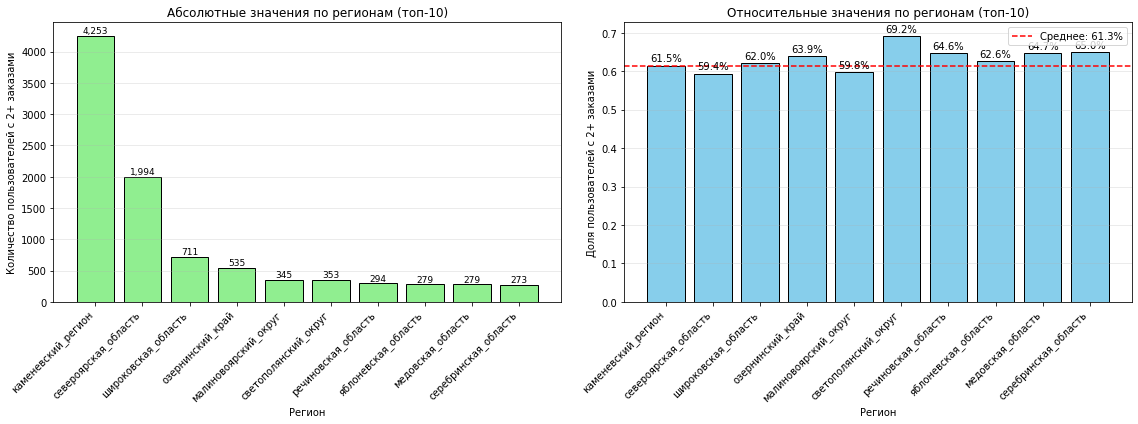

In [79]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Берем топ-10 регионов
top_regions = region_retention.head(10)
x = np.arange(len(top_regions))

# Абсолютный
bars1_abs = ax1.bar(x, top_regions['users_with_2plus'], 
                    color='lightgreen', edgecolor='black')
ax1.set_xlabel('Регион')
ax1.set_ylabel('Количество пользователей с 2+ заказами')
ax1.set_title('Абсолютные значения по регионам (топ-10)')
ax1.set_xticks(x)
ax1.set_xticklabels(top_regions.index, rotation=45, ha='right')
ax1.grid(True, alpha=0.3, axis='y')

# Добавляем значения на абсолютный график
for i, count in enumerate(top_regions['users_with_2plus']):
    ax1.text(i, count + max(top_regions['users_with_2plus'])*0.01, 
             f'{count:,}', ha='center', fontsize=9)

# Относительный 
bars2_rel = ax2.bar(x, top_regions['retention_2plus'], 
                    color='skyblue', edgecolor='black')
ax2.set_xlabel('Регион')
ax2.set_ylabel('Доля пользователей с 2+ заказами')
ax2.set_title('Относительные значения по регионам (топ-10)')
ax2.set_xticks(x)
ax2.set_xticklabels(top_regions.index, rotation=45, ha='right')

# Линия среднего
ax2.axhline(y=avg_retention, color='red', linestyle='--', 
            label=f'Среднее: {avg_retention:.1%}')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Добавляем значения на относительный график
for i, rate in enumerate(top_regions['retention_2plus']):
    ax2.text(i, rate + 0.01, f'{rate:.1%}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

Географическое распределение `retention` относительно равномерно: все крупные регионы показывают значения в диапазоне `59–64%`. Лидером является `Озернинский край` c `63,9%`, но разница с другими регионами несущественна. Это говорит об отсутствии выраженных региональных особенностей в лояльности пользователей — сервис равномерно эффективен в разных географических сегментах.

In [80]:
#Для билетного оператора 
service_retention = (user_profile_clear.groupby('first_service')
                     .agg(
                         total_users=('user_id', 'count'),
                         users_with_2plus=('is_two', 'sum'),
                         users_with_5plus=('is_five', 'sum')
                     )
                     .assign(
                         retention_2plus=lambda x: x['users_with_2plus'] / x['total_users'],
                         retention_5plus=lambda x: x['users_with_5plus'] / x['total_users']
                     )
                     .sort_values('total_users', ascending=False))

service_retention

,total_users,users_with_2plus,users_with_5plus,retention_2plus,retention_5plus
first_service,,,,,
билеты_без_проблем,4806,2756,1230,0.573450,0.255930
мой_билет,2979,1817,869,0.609936,0.291709
лови_билет!,2967,1869,887,0.629929,0.298955
билеты_в_руки,2414,1462,674,0.605634,0.279205
облачко,2193,1349,593,0.615139,0.270406
лучшие_билеты,1384,927,438,0.669798,0.316474
весь_в_билетах,1260,783,339,0.621429,0.269048
прачечная,598,380,178,0.635452,0.297659
яблоко,409,261,146,0.638142,0.356968


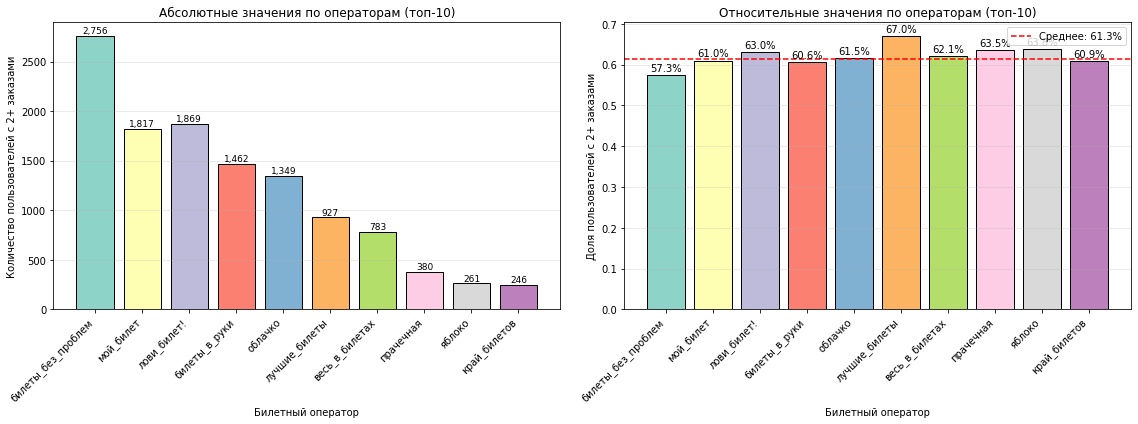

In [81]:
# Берем топ-10 сервисов по количеству пользователей
top_services = service_retention.head(10)

# Создаем фигуру с двумя графиками
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

x = np.arange(len(top_services))

# 1. Абсолютный
bars1 = ax1.bar(x, top_services['users_with_2plus'], 
                color=plt.cm.Set3(range(len(top_services))), 
                edgecolor='black')

ax1.set_xlabel('Билетный оператор')
ax1.set_ylabel('Количество пользователей с 2+ заказами')
ax1.set_title('Абсолютные значения по операторам (топ-10)')
ax1.set_xticks(x)
ax1.set_xticklabels(top_services.index, rotation=45, ha='right')
ax1.grid(True, alpha=0.3, axis='y')

# Добавляем значения на абсолютный график
for i, count in enumerate(top_services['users_with_2plus']):
    ax1.text(i, count + max(top_services['users_with_2plus'])*0.01, 
             f'{count:,}', ha='center', fontsize=9)

# 2. Относительный 
bars2 = ax2.bar(x, top_services['retention_2plus'], 
                color=plt.cm.Set3(range(len(top_services))), 
                edgecolor='black')

ax2.set_xlabel('Билетный оператор')
ax2.set_ylabel('Доля пользователей с 2+ заказами')
ax2.set_title('Относительные значения по операторам (топ-10)')
ax2.set_xticks(x)
ax2.set_xticklabels(top_services.index, rotation=45, ha='right')

# Линия среднего
avg_retention = user_profile_clear['is_two'].mean()
ax2.axhline(y=avg_retention, color='red', linestyle='--', 
            label=f'Среднее: {avg_retention:.1%}')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Добавляем значения на относительный график
for i, rate in enumerate(top_services['retention_2plus']):
    ax2.text(i, rate + 0.01, f'{rate:.1%}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

Наблюдается обратная зависимость между размером оператора и `retention`: крупнейший оператор `"билеты_без_проблем"` `4 806` пользователей имеет один из самых низких показателей `57,3%`, в то время как меньшие операторы `"тебе_билет!"` и  `"лучшие_билеты"` демонстрируют `retention` `67–69%`. Это может указывать либо на специфику аудитории разных операторов, либо на то, что крупные игроки привлекают более широкую, но менее лояльную аудиторию

**Вывод**
Анализ `retention` по сегментам выявил, что наиболее массовые `"точки входа"` не обеспечивают максимальной лояльности. Меньшие по объёму сегменты часто демонстрируют более высокий `retention`. Нельзя сказать, что только обслуживание оператора при покупке билета влияет на их `retention`, так как путь клиента содержит впечатления от самого мероприятия и обслуживания там. Однозначно можно сказать, что использование мобильных устройств и наличие удобного приложения для покупки билетов играет важную роль в нише. Так как основную долю покупок совершают именно с мобильных устройств. Наиболее востребованные жанры являются `спорт` и `театр`, что можно использовать в рамках рекламныз компаний по привлечению новых клиентов и возврату ушедших. 

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

Нулевая гипотеза:
Тип первого мероприятия не влияет на вероятность совершения повторного заказа.
Доли пользователей, совершивших повторный заказ, одинаковы в группах «спорт» и «концерты».

Не нулевая гипотеза:
Пользователи, чей первый заказ был на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, начавшие с концертов.
Доля повторных заказов в группе «спорт» больше, чем в группе «концерты».

In [82]:
from scipy.stats import chi2_contingency, fisher_exact

#создаю признак
user_profile_clear['is_repeat'] = (user_profile_clear['total_orders'] >= 2).astype(int)

# Записываю в переменную названия
sport_genre = 'спорт'
concert_genre = 'концерты'

# Фильтрация групп
sport_users = user_profile_clear[user_profile_clear['first_genre'] == sport_genre].copy()
concert_users = user_profile_clear[user_profile_clear['first_genre'] == concert_genre].copy()

n_sport = len(sport_users)
n_concert = len(concert_users)


repeat_sport = sport_users['is_repeat'].sum()
repeat_concert = concert_users['is_repeat'].sum()
p_sport = repeat_sport / n_sport
p_concert = repeat_concert / n_concert

print(f"Спорт: {n_sport}, повторных {repeat_sport} ({p_sport:.2%})")
print(f"Концерты: {n_concert}, повторных {repeat_concert} ({p_concert:.2%})")

# Таблица сопряжённости 2×2
table = np.array([
    [repeat_sport, n_sport - repeat_sport],
    [repeat_concert, n_concert - repeat_concert]
])

# Расчёт ожидаемых частот
chi2, p, dof, expected = chi2_contingency(table)

print(f"Значение хи-квадрат: {chi2}")
print(f"P-значение: {p}")
print(f"Степени свободы: {dof}")
print("Ожидаемые значения:")
print(expected)


alpha = 0.05
if p < alpha:
    print(f"\n p-value < {alpha} → нулевая гипотеза отвергается.")
else:
    print(f"\n p-value ≥ {alpha} → нет оснований отвергнуть нулевую гипотезу.")
    print("   Различия статистически не значимы.")


Спорт: 1038, повторных 687 (66.18%)
Концерты: 9200, повторных 5548 (60.30%)
Значение хи-квадрат: 13.300596439348075
P-значение: 0.00026532170165335245
Степени свободы: 1
Ожидаемые значения:
[[ 632.14788045  405.85211955]
 [5602.85211955 3597.14788045]]

 p-value < 0.05 → нулевая гипотеза отвергается.


/tmp/ipykernel_139/2330465023.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_profile_clear['is_repeat'] = (user_profile_clear['total_orders'] >= 2).astype(int)


In [83]:
oddsratio, p_value = fisher_exact(table)

print(f"Odds ratio: {oddsratio}")
print(f"P-value: {p_value}")

if p_value < alpha:
    print(f"\n p-value < {alpha} → нулевая гипотеза отвергается.")
else:
    print(f"\n p-value ≥ {alpha} → нет оснований отвергнуть нулевую гипотезу.")
    print("   Различия статистически не значимы.")


Odds ratio: 1.2883798889566733
P-value: 0.00022183174513834986

 p-value < 0.05 → нулевая гипотеза отвергается.


Пользователи, начавшие со спортивных мероприятий, демонстрируют значимо более высокую долю повторных заказов `66,2%`, чем начавшие с концертов `60,3%`. Разница составляет `5,9` процентных пункта, отношение шансов — `1,29`. Оба теста (`хи-квадрат Пирсона` и точный `критерий Фишера`) дают `p-значения` `~0,0002–0,0003`, что значительно `ниже порога 0,05`. Таким образом, **нулевая гипотеза об отсутствии связи между жанром первого мероприятия и повторным заказом отвергается**. Статистически подтверждено, что спортивная аудитория возвращается чаще концертной. 

Нулевая гипотеза:
Доля повторных заказов в регионах с высокой активностью пользователей не отличается от доли в менее активных регионах.
Региональная популярность не влияет на вероятность возврата.

Не нулевая гипотеза:
В регионах с наибольшим количеством пользователей доля повторных заказов выше, чем в менее активных регионах.
Активные регионы имеют более лояльную аудиторию.

In [84]:
# Подсчёт числа пользователей в каждом регионе
region_counts = user_profile_clear['first_region'].value_counts()
print("Распределение пользователей по регионам (топ-10):")
print(region_counts.head(10))

# Задаём количество топ-регионов, которые будем считать "активными"
n_top_regions = 5
active_regions = region_counts.head(n_top_regions).index.tolist()
print(f"\nАктивные регионы (топ-{n_top_regions}): {active_regions}")

# Создаём бинарный признак активности региона
user_profile_clear['is_active_region'] = user_profile_clear['first_region'].isin(active_regions)

# --- Фильтруем группы ---
active_users = user_profile_clear[user_profile_clear['is_active_region'] == True].copy()
inactive_users = user_profile_clear[user_profile_clear['is_active_region'] == False].copy()

n_active = len(active_users)
n_inactive = len(inactive_users)

# Подсчёт повторных заказов в каждой группе
repeat_active = active_users['is_repeat'].sum()
repeat_inactive = inactive_users['is_repeat'].sum()

p_active = repeat_active / n_active if n_active > 0 else 0
p_inactive = repeat_inactive / n_inactive if n_inactive > 0 else 0

print(f"\nАктивные регионы:   всего {n_active}, повторных {repeat_active} ({p_active:.2%})")
print(f"Неактивные регионы: всего {n_inactive}, повторных {repeat_inactive} ({p_inactive:.2%})")

# таблица сопряженности
table = np.array([
    [repeat_active, n_active - repeat_active],
    [repeat_inactive, n_inactive - repeat_inactive]
])

# критерий хи
chi2, p, dof, expected = chi2_contingency(table, correction=False)
print(f"Значение хи-квадрат: {chi2}")
print(f"P-значение: {p}")
print(f"Степени свободы: {dof}")
print("Ожидаемые значения:")
print(expected)


# критерий фишера
# Используем alternative='greater' для проверки, что в активных регионах доля выше
oddsratio, p_fisher = fisher_exact(table)
print(f"Odds ratio = {oddsratio:.4f}")
print(f"p-value = {p_fisher:.5f}")

# вывод
if p < alpha:
    print(f"\n p-value < {alpha} → нулевая гипотеза отвергается.")
else:
    print(f"\n p-value ≥ {alpha} → нет оснований отвергнуть нулевую гипотезу.")
    print("   Различия статистически не значимы.")

/tmp/ipykernel_139/3151081320.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_profile_clear['is_active_region'] = user_profile_clear['first_region'].isin(active_regions)


Распределение пользователей по регионам (топ-10):
каменевский_регион      6918
североярская_область    3357
широковская_область     1146
озернинский_край         837
малиновоярский_округ     577
светополянский_округ     510
речиновская_область      455
яблоневская_область      446
медовская_область        431
серебринская_область     420
Name: first_region, dtype: int64

Активные регионы (топ-5): ['каменевский_регион', 'североярская_область', 'широковская_область', 'озернинский_край', 'малиновоярский_округ']

Активные регионы:   всего 12835, повторных 7838 (61.07%)
Неактивные регионы: всего 8787, повторных 5421 (61.69%)
Значение хи-квадрат: 0.8618497821029246
P-значение: 0.35322156047995523
Степени свободы: 1
Ожидаемые значения:
[[7870.65326982 4964.34673018]
 [5388.34673018 3398.65326982]]
Odds ratio = 0.9739
p-value = 0.35551

 p-value ≥ 0.05 → нет оснований отвергнуть нулевую гипотезу.
   Различия статистически не значимы.


Результаты тестирования показывают, что доля повторных заказов в активных регионах `61,07%` практически не отличается от доли в менее активных регионах `61,69%`, причём наблюдается даже незначительное снижение. Хи-квадрат даёт p = `0,353`, точный критерий Фишера p = `0,355`. Оба значения значительно выше порога 0,05, поэтому нулевая гипотеза не отвергается. Статистически значимых доказательств того, что в регионах с наибольшим числом пользователей доля повторных заказов выше, не обнаружено. Гипотеза не подтверждается. 

**Проведённый анализ первых заказов пользователей и их последующего поведения позволил выявить ключевые закономерности, связывающие сегментацию по первому взаимодействию с сервисом и вероятность повторных покупок.**

1. Жанр первого мероприятия
Распределение: почти `87%` пользователей приходят через три жанра – концерты `42,5%`, другое `23,7%` и театр `21,1%`. Это «точки входа», формирующие основной поток клиентов.

Удержание: наиболее высокий уровень повторных заказов наблюдается у пользователей, впервые купивших билеты на спорт `66,2%` и театр `~66%`. Статистический тест подтвердил, что разница между спортом и концертами `60,3%` значима (`p < 0,001`). Жанр «ёлки» демонстрирует экстремально высокий `retention` `79,5%`, однако из-за малого размера группы `205 человек` этот результат скорее точечный и не может служить основой для массовых стратегий.


2. Тип устройства при первом заказе
Доминирование мобильных: `82,9%` пользователей впервые приходят через смартфоны.

Удержание: `retention` среди владельцев десктопов `63,7%` незначительно выше, чем у мобильных пользователей `60,8%`. Разница мала и вряд ли является стратегически важной.

3. Регион первого заказа
Концентрация: почти половина пользователей сосредоточена в двух регионах – Каменевском `32,0%` и Североярской области `15,5%`. Остальные `81` регион имеют минимальную долю.

Удержание: `retention` в активных регионах `61,1%` практически идентичен показателю в менее активных `61,7%`. Статистический тест показал отсутствие значимых различий `p = 0,35`.

4. Оператор (сервис) первого заказа
Конкуренция: `топ-5` операторов занимают `71%` рынка, но лидер `билеты_без_проблем` имеет лишь `22,2%` пользователей.

Удержание: наблюдается обратная зависимость между размером оператора и долей повторных покупателей. Крупнейший оператор показывает `retention` `57,3%`, в то время как многие мелкие сервисы достигают `67–69%` (например, «тебе_билет!» – `68,9%`, «лучшие_билеты» – `66,9%`).

ИТОГО: 
- Массовые сегменты (концерты, мобильные устройства, крупные регионы, лидирующие операторы) обеспечивают основной приток новых клиентов, но не дают максимальной лояльности.

- Нишевые сегменты (спорт, театр, мелкие операторы) показывают более высокий retention, что открывает возможности для точечных маркетинговых кампаний, направленных на удержание, а также для адаптации предложений под эти аудитории.

- География не является фактором, влияющим на возвращаемость, поэтому региональная экспансия может проводиться без опасений за падение лояльности.

- Мобильное приложение – ключевой канал взаимодействия, и его качество напрямую сказывается на удержании, однако пользователи десктопа остаются чуть более стабильными (вероятно, за счёт более осознанных покупок).

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


In [85]:
# Разделяем пользователей на группы
one_order_users = user_profile_clear[user_profile_clear['total_orders'] == 1]
returned_users = user_profile_clear[user_profile_clear['total_orders'] >= 2]

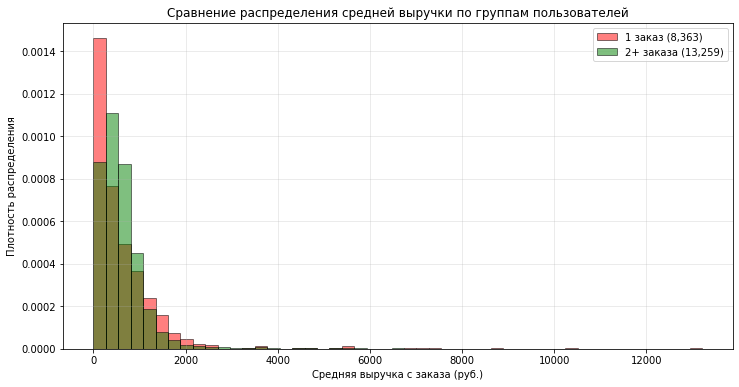

In [86]:
# Сначала определим общие параметры для гистограмм
min_rev = user_profile_clear['avg_revenue'].min()
max_rev = user_profile_clear['avg_revenue'].max()
bins = np.linspace(min_rev, max_rev, 50)

# Сравнительная гистограмма на одном графике
plt.figure(figsize=(12, 6))

# Используем одинаковые интервалы
plt.hist(one_order_users['avg_revenue'], bins=bins, alpha=0.5, color='red', 
         density=True, edgecolor='black', label='1 заказ ({:,})'.format(len(one_order_users)))
plt.hist(returned_users['avg_revenue'], bins=bins, alpha=0.5, color='green', 
         density=True, edgecolor='black', label='2+ заказа ({:,})'.format(len(returned_users)))

plt.xlabel('Средняя выручка с заказа (руб.)')
plt.ylabel('Плотность распределения')
plt.title('Сравнение распределения средней выручки по группам пользователей')
plt.legend()
plt.grid(True, alpha=0.3)


# Выводим ключевую статистику
stats_text = (f'Сравнительная статистика:\n'
              f'Медиана (1 заказ): {one_order_users["avg_revenue"].median():.0f} руб.\n'
              f'Медиана (2+ заказа): {returned_users["avg_revenue"].median():.0f} руб.\n'
              f'Среднее (1 заказ): {one_order_users["avg_revenue"].mean():.0f} руб.\n'
              f'Среднее (2+ заказа): {returned_users["avg_revenue"].mean():.0f} руб.')

plt.show()

In [87]:
one_order_users['avg_revenue'].describe()

count     8363.000000
mean       641.473934
std        958.402069
min          0.000000
25%        142.355000
50%        391.550000
75%        856.800000
max      13212.930000
Name: avg_revenue, dtype: float64

In [88]:
returned_users['avg_revenue'].describe()

count    13259.000000
mean       630.555219
std        710.721070
min          0.000000
25%        282.402500
50%        509.458500
75%        776.789583
max      13212.930000
Name: avg_revenue, dtype: float64

In [89]:
# Рассчитываем ключевые различия
median_diff = returned_users['avg_revenue'].median() - one_order_users['avg_revenue'].median()
q25_diff = returned_users['avg_revenue'].quantile(0.25) - one_order_users['avg_revenue'].quantile(0.25)
q75_diff = returned_users['avg_revenue'].quantile(0.75) - one_order_users['avg_revenue'].quantile(0.75)
mean_diff = returned_users['avg_revenue'].mean() - one_order_users['avg_revenue'].mean()
std_diff = returned_users['avg_revenue'].std() - one_order_users['avg_revenue'].std()

#Так как размах у обоих групп одинаковый, считаем по квартилям
one_IQR = one_order_users['avg_revenue'].quantile(0.75) - one_order_users['avg_revenue'].quantile(0.25)
two_IQR = returned_users['avg_revenue'].quantile(0.75) - returned_users['avg_revenue'].quantile(0.25)


print(f"Разница медиан: {median_diff:+.0f} руб.")
print(f"Разница 25%: {q25_diff:+.0f} руб.")
print(f"Разница 75%: {q75_diff:+.0f} руб.")
print(f"Разница средних: {mean_diff:+.0f} руб.")
print(f"Разница std: {std_diff:+.0f} руб.")
print(f"Разница размаха: {two_IQR - one_IQR:+.0f} руб.")

Разница медиан: +118 руб.
Разница 25%: +140 руб.
Разница 75%: -80 руб.
Разница средних: -11 руб.
Разница std: -248 руб.
Разница размаха: -220 руб.


Пользователи обеих групп концентрируются в диапазоне `300-800` рублей, но вернувшиеся пользователи смещены к более высоким значениям: их медиана на `118` рублей выше. Различия между группами значительны:
 - Размах первой группы (с `1` покупкой) превышает размах второй группы на `220` руб.
 - Разница в стандартном отклоненнии первой группы также значительно выше, что говорит о большей непредсказуемости покупок первых групп. 

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [90]:
# Разделяем пользователей на группы
group_2_4 = user_profile_clear[(user_profile_clear['total_orders'] >= 2) & (user_profile_clear['total_orders'] <= 4)]
group_5plus = user_profile_clear[user_profile_clear['total_orders'] >= 5]

In [91]:
# Определяем общие интервалы
min_rev = min(group_2_4['avg_revenue'].min(), group_5plus['avg_revenue'].min())
max_rev = max(group_2_4['avg_revenue'].max(), group_5plus['avg_revenue'].max())
bins = np.linspace(min_rev, max_rev, 50)

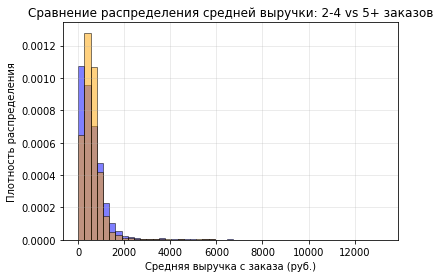

In [92]:
# Строим гистограммы
plt.hist(group_2_4['avg_revenue'], bins=bins, alpha=0.5, color='blue', 
         density=True, edgecolor='black', label='2-4 заказа ({:,})'.format(len(group_2_4)))
plt.hist(group_5plus['avg_revenue'], bins=bins, alpha=0.5, color='orange', 
         density=True, edgecolor='black', label='5+ заказов ({:,})'.format(len(group_5plus)))

plt.xlabel('Средняя выручка с заказа (руб.)')
plt.ylabel('Плотность распределения')
plt.title('Сравнение распределения средней выручки: 2-4 vs 5+ заказов')

plt.grid(True, alpha=0.3)

In [93]:
# Рассчитываем ключевые различия
median_diff_ret = group_5plus['avg_revenue'].median() - group_2_4['avg_revenue'].median()
q25_diff_ret = group_5plus['avg_revenue'].quantile(0.25) - group_2_4['avg_revenue'].quantile(0.25)
q75_diff_ret = group_5plus['avg_revenue'].quantile(0.75) - group_2_4['avg_revenue'].quantile(0.75)
mean_diff_ret = group_5plus['avg_revenue'].mean() - group_2_4['avg_revenue'].mean()
std_diff_ret = group_5plus['avg_revenue'].std() - group_2_4['avg_revenue'].std()

#Так как размах у обоих групп одинаковый, считаем по квартилям
two_four_IQR = group_2_4['avg_revenue'].quantile(0.75) - group_2_4['avg_revenue'].quantile(0.25)
five_IQR = group_5plus['avg_revenue'].quantile(0.75) - group_5plus['avg_revenue'].quantile(0.25)


print(f"Разница медиан: {median_diff_ret:+.0f} руб.")
print(f"Разница 25%: {q25_diff_ret:+.0f} руб.")
print(f"Разница 75%: {q75_diff_ret:+.0f} руб.")
print(f"Разница средних: {mean_diff_ret:+.0f} руб.")
print(f"Разница std: {std_diff_ret:+.0f} руб.")
print(f"Разница размаха: {five_IQR - two_four_IQR:+.0f} руб.")

Разница медиан: +45 руб.
Разница 25%: +113 руб.
Разница 75%: -92 руб.
Разница средних: -40 руб.
Разница std: -279 руб.
Разница размаха: -205 руб.


Различия есть, но они качественные, а не количественные: `5+` пользователи платят стабильно средне, `2-4` пользователи имеют более широкий `разброс` с возможностью как очень дешевых, так и очень дорогих заказов.

Вернувшиеся пользователи представляют собой более стабильную и «качественную» аудиторию. Они не склонны к спонтанным очень дешёвым покупкам (возможно, пробным), но и не совершают разовых сверхдорогих заказов. Их поведение укладывается в «коридор» средних цен, что делает их предсказуемыми для бизнеса.
Напротив, группа с одной покупкой крайне неоднородна: в ней присутствуют как «экономные» клиенты (с низкими чеками), так и «вип-гости» с очень высокими тратами, которые по какой-то причине не возвращаются. Возможно, последние приходят на уникальные события (гастроли звёзд, фестивали) и не являются постоянной аудиторией, либо их опыт взаимодействия с сервисом оказался недостаточно хорош для повторного визита.

С ростом числа покупок клиенты становятся более консервативными в выборе ценовых категорий. Они находят свой «комфортный» уровень цен и придерживаются его. Это может быть связано с привычкой к определённым типам мероприятий, площадкам или сформировавшимся бюджетом на досуг. Такие пользователи — «ядро» аудитории, на которое можно опираться при планировании программ лояльности и персонализированных предложений.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

count    21622.000000
mean         2.744257
std          0.917477
min          1.000000
25%          2.000000
50%          2.750000
75%          3.100000
max         11.000000
Name: avg_ticket_count, dtype: float64


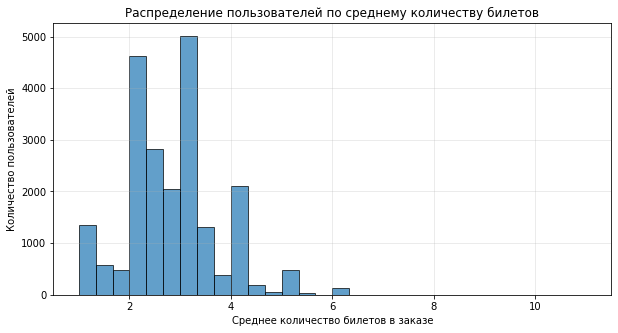

In [94]:
# Вывожу общее распределение
print(user_profile_clear['avg_ticket_count'].describe())

plt.figure(figsize=(10, 5))
plt.hist(user_profile_clear['avg_ticket_count'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Среднее количество билетов в заказе')
plt.ylabel('Количество пользователей')
plt.title('Распределение пользователей по среднему количеству билетов')
plt.grid(True, alpha=0.3)
plt.show()

/tmp/ipykernel_139/497803918.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_profile_clear['ticket_segment'] = pd.cut(
/tmp/ipykernel_139/497803918.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_profile_clear['ticket_segment'] = pd.Categorical(


,total_users,repeat_users,repeat_share
ticket_segment,,,
1-2 билета,2410,1235,51.2
2-3 билета,9486,6978,73.6
3-5 билетов,9065,4922,54.3
5+ билетов,661,124,18.8


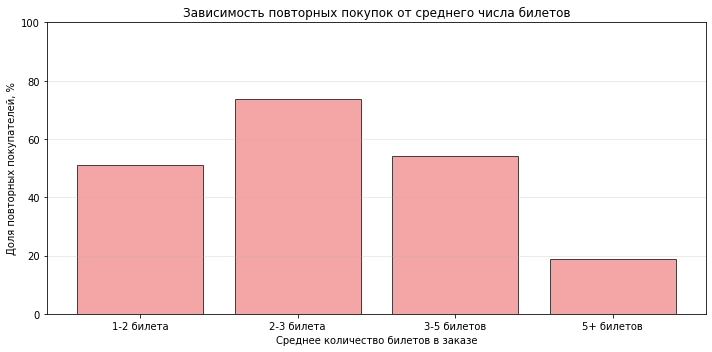

   - 1-2 билета: 51.2% (всего 2,410.0 пользователей)
   - 2-3 билета: 73.6% (всего 9,486.0 пользователей)
   - 3-5 билетов: 54.3% (всего 9,065.0 пользователей)
   - 5+ билетов: 18.8% (всего 661.0 пользователей)


In [95]:
bins = [1, 2, 3, 5, np.inf]
labels = ['1-2 билета', '2-3 билета', '3-5 билетов', '5+ билетов']
user_profile_clear['ticket_segment'] = pd.cut(
        user_profile_clear['avg_ticket_count'],
        bins=bins,
        labels=labels,
        right=False
    )

# Приводим к категориальному признаку
ordered_labels = ['1-2 билета', '2-3 билета', '3-5 билетов', '5+ билетов']
user_profile_clear['ticket_segment'] = pd.Categorical(
    user_profile_clear['ticket_segment'],
    categories=ordered_labels,
    ordered=True
)

# Группировка и расчёт метрик
segment_analysis = (user_profile_clear.groupby('ticket_segment', observed=True)
                    .agg(
                        total_users=('user_id', 'count'),
                        repeat_users=('is_repeat', 'sum')   # сумма по столбцу is_repeat (1/True)
                    )
                    .assign(
                        repeat_share=lambda x: (x['repeat_users'] / x['total_users'] * 100).round(1)
                    )
                   )

display(segment_analysis)

# Визуализация
plt.figure(figsize=(10, 5))
bars = plt.bar(segment_analysis.index, segment_analysis['repeat_share'],
               color='lightcoral', edgecolor='black', alpha=0.7)

plt.xlabel('Среднее количество билетов в заказе')
plt.ylabel('Доля повторных покупателей, %')
plt.title('Зависимость повторных покупок от среднего числа билетов')
plt.ylim(0, 100)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


for label in ordered_labels:
    if label in segment_analysis.index:
        row = segment_analysis.loc[label]
        print(f"   - {label}: {row['repeat_share']}% (всего {row['total_users']:,} пользователей)")


Пользователи распределены крайне неравномерно:

   - 1-2 билета: 51.2% (всего 2,410.0 пользователей)
   - 2-3 билета: 73.6% (всего 9,486.0 пользователей)
   - 3-5 билетов: 54.3% (всего 9,065.0 пользователей)
   - 5+ билетов: 18.8% (всего 661.0 пользователей)

Основная масса пользователей (85,8%) сосредоточена в двух средних сегментах – 2–3 и 3–5 билетов. Крайние сегменты (самые маленькие и самые большие покупки) занимают лишь около 14% аудитории. Это говорит о том, что типичный клиент покупает от 2 до 5 билетов в среднем за заказ.

Наблюдаются две аномалии:

- Аномально высокая доля возвратов в сегменте 2–3 билета (почти три четверти пользователей возвращаются).

- Аномально низкая доля в сегменте 5+ билетов (менее 19% повторных заказов).


Сегмент 1–2 билета (51,2%)
Скорее всего, это одиночные посетители или пары, которые приходят на мероприятия от случая к случаю. Половина из них возвращается – это неплохой показатель, но потенциал для роста ещё есть. Возможно, им не хватает напоминания для повторного визита.

Сегмент 2–3 билета (73,6%)
Наиболее лояльная группа. Вероятно, это небольшие компании друзей, семейные пары с детьми или группы коллег, которые регулярно посещают мероприятия вместе. Они уже сформировали привычку и, видимо, находят на платформе подходящий контент. Высокая возвращаемость может быть связана с тем, что покупка билетов для 2–3 человек – это удобный формат для большинства событий, и такие клиенты чаще других планируют досуг заранее.

Сегмент 3–5 билетов (54,3%)
Здесь также много пользователей (почти 42%), но возвращаемость заметно ниже, чем в предыдущем сегменте. Это могут быть более крупные компании (например, дни рождения, корпоративы), которые организуются реже. Возможно, часть из них приходит только на масштабные события, которые происходят не каждый месяц, отсюда и меньшая частота повторных заказов.

Сегмент 5+ билетов (18,8%)
Самый маленький по численности, но с минимальной долей возвратов. Скорее всего, это корпоративные клиенты, организованные группы (школы, экскурсии) или люди, покупающие билеты для больших компаний по особым случаям. Такие покупки – событийные, и в течение года они могут повторяться редко (например, раз в год на фестиваль или новогодние ёлки). Также возможно, что часть этих заказов – разовые спонтанные акции (например, покупка билетов для всей команды на разовое мероприятие). Как вариант можно делать рассылку по учебным заведениям с персональным предложением. 

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [96]:
user_profile_clear['first_weekday'] = user_profile_clear['first_dt'].dt.day_name()
# кол-во пользователей в сегментах, их доля от общего числа + кол-во пользователей в сегментах с повтороной продажей и их доля от общего числа пользователей в сегменте.
weekday_distribution = (
    user_profile_clear
    .groupby('first_weekday')
    .agg(
        total_users=('user_id', 'count'),
        users_with_2plus=('is_two', 'sum')
    )
    .assign(
        segment_share=lambda x: (x['total_users'] / len(user_profile_clear)).round(3),
        repeat_share=lambda x: (x['users_with_2plus'] / x['total_users']).round(3)
    ))

weekday_distribution

/tmp/ipykernel_139/3724933378.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_profile_clear['first_weekday'] = user_profile_clear['first_dt'].dt.day_name()


,total_users,users_with_2plus,segment_share,repeat_share
first_weekday,,,,
Friday,3052,1742,0.141,0.571
Monday,2708,1628,0.125,0.601
Saturday,3022,1785,0.140,0.591
Sunday,2684,1575,0.124,0.587
Thursday,3716,2454,0.172,0.660
Tuesday,3178,1968,0.147,0.619
Wednesday,3262,2107,0.151,0.646


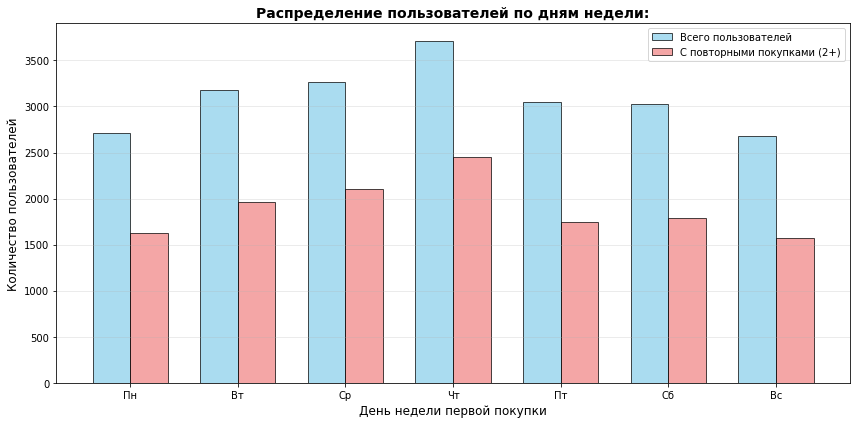

In [97]:
# Определяем правильный порядок дней недели для графика
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_labels_ru = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']

# Переиндексируем данные в правильном порядке
weekday_distribution_sorted = weekday_distribution.reindex(weekday_order)

# Создаем график
fig, ax1 = plt.subplots(figsize=(12, 6))

# Позиции для столбцов
x = np.arange(len(weekday_labels_ru))
width = 0.35  # Ширина столбцов

# Столбчатая диаграмма - общее количество пользователей
bars1 = ax1.bar(x - width/2, weekday_distribution_sorted['total_users'],
                width, color='skyblue', edgecolor='black', alpha=0.7, 
                label='Всего пользователей')

# Столбчатая диаграмма - количество пользователей с повторными покупками
bars2 = ax1.bar(x + width/2, weekday_distribution_sorted['users_with_2plus'],
                width, color='lightcoral', edgecolor='black', alpha=0.7,
                label='С повторными покупками (2+)')

# Настройки осей
ax1.set_xlabel('День недели первой покупки', fontsize=12)
ax1.set_ylabel('Количество пользователей', fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(weekday_labels_ru)


plt.title('Распределение пользователей по дням недели:', fontsize=14, fontweight='bold')
ax1.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

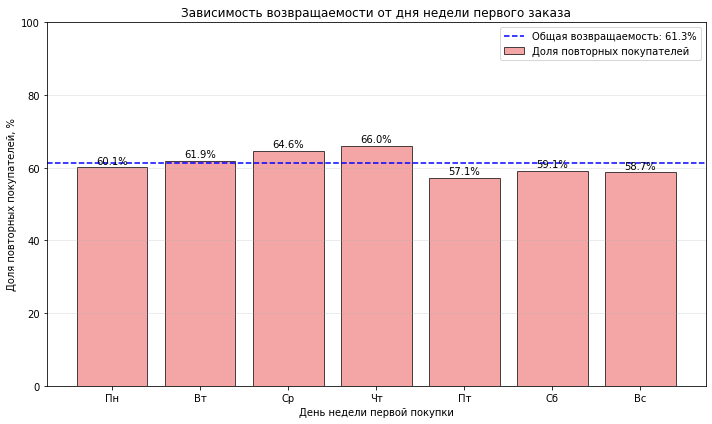

Данные по дням недели:


,total_users,users_with_2plus,repeat_share
first_weekday,,,
Monday,2708,1628,0.601
Tuesday,3178,1968,0.619
Wednesday,3262,2107,0.646
Thursday,3716,2454,0.660
Friday,3052,1742,0.571
Saturday,3022,1785,0.591
Sunday,2684,1575,0.587


In [98]:
# Общая доля повторных покупателей (в процентах)
overall_repeat_share = (user_profile_clear['is_two'].sum() / 
                        len(user_profile_clear) * 100)

# Преобразуем repeat_share из долей в проценты
repeat_share_pct = weekday_distribution_sorted['repeat_share'] * 100

plt.figure(figsize=(10, 6))
bars = plt.bar(weekday_labels_ru, repeat_share_pct,
               color='lightcoral', edgecolor='black', alpha=0.7,
               label='Доля повторных покупателей')

# Горизонтальная линия общей возвращаемости
plt.axhline(y=overall_repeat_share, color='blue', linestyle='--',
            linewidth=1.5, label=f'Общая возвращаемость: {overall_repeat_share:.1f}%')

plt.xlabel('День недели первой покупки')
plt.ylabel('Доля повторных покупателей, %')
plt.title('Зависимость возвращаемости от дня недели первого заказа')
plt.ylim(0, 100)
plt.grid(True, alpha=0.3, axis='y')
plt.legend()

# Подписи значений над столбцами
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1,
             f'{height:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Для наглядности выведем таблицу с данными (необязательно)
print("Данные по дням недели:")
display(weekday_distribution_sorted[['total_users', 'users_with_2plus', 'repeat_share']])

Распределение пользователей по дням недели первой покупки неравномерное: наибольшее количество новых пользователей приходит в четверг (`17,2%` от всех), наименьшее — в воскресенье (`12,4%`). При этом наибольшая доля пользователей, совершивших повторные покупки, также наблюдается в четверг (`66,0%`), а наименьшая — в пятницу (`57,1%`). Также можно заметить увеличение спроса в начале недели и снижение спроса к концу недели, это может говорить о том, что люди чаще посещают мероприятия в выходные дни, а покупают мероприятия в будние. 

Можно утверждать, что день недели первой покупки влияет на вероятность возврата клиента. Наблюдается значительный разброс доли пользователей, совершивших повторные покупки: от `57,1%` в пятницу до `66,0%` в четверг, что составляет разницу в `8,9`%. Это указывает на то, что пользователи, начавшие взаимодействие с сервисом в середине недели (вторник-четверг), демонстрируют более высокую лояльность по сравнению с теми, кто совершил первую покупку в конце недели (пятница-воскресенье). Для бизнеса это означает, что в четверг стоит усиливать маркетинговые кампании, а в пятницу – использовать механики для стимулирования повторных покупок прямо в момент заказа.

Четверг лидирует по возвращаемости, вероятно, потому что в этот день люди уже планируют выходные, выбирают мероприятия осознанно и заранее – такие клиенты более вовлечены и лояльны. Пятница же, наоборот, день спонтанных покупок («куда сходить сегодня вечером?»), и эти пользователи реже возвращаются, так как их решение сиюминутное и не формирует привычки.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [99]:
# Создаем сводную таблицу
summary_table = pd.DataFrame({
    'Группа': ['2-4 заказа', '5+ заказов'],
    'Количество пользователей': [
        len(group_2_4),
        len(group_5plus)
    ],
    'Средний интервал между заказами (дни)': [
        group_2_4['avg_days_since_prev'].mean(),
        group_5plus['avg_days_since_prev'].mean()
    ],
    'Медианный интервал между заказами (дни)': [
        group_2_4['avg_days_since_prev'].median(),
        group_5plus['avg_days_since_prev'].median()
    ],
    'Стандартное отклонение': [
        group_2_4['avg_days_since_prev'].std(),
        group_5plus['avg_days_since_prev'].std()
    ]
})

summary_table

,Группа,Количество пользователей,Средний интервал между заказами (дни),Медианный интервал между заказами (дни),Стандартное отклонение
0,2-4 заказа,7145,21.336296,9.000000,28.503546
1,5+ заказов,6114,9.915620,8.138095,7.810002


In [100]:
# Создаем категории для интервалов
bins = [0, 7, 14, 30, 60, 90, 180, float('inf')]
labels = ['0-7', '8-14', '15-30', '31-60', '61-90', '91-180', '181+']

# Группируем данные по интервалам
group_2_4['interval_category'] = pd.cut(group_2_4['avg_days_since_prev'], bins=bins, labels=labels, right=False)
group_5plus['interval_category'] = pd.cut(group_5plus['avg_days_since_prev'], bins=bins, labels=labels, right=False)

# Создаем таблицу распределения
interval_distribution = pd.DataFrame({
    'Интервал (дни)': labels,
    'Кол-во (2-4 заказа)': group_2_4['interval_category'].value_counts().reindex(labels).fillna(0).astype(int).values,
    'Кол-во (5+ заказов)': group_5plus['interval_category'].value_counts().reindex(labels).fillna(0).astype(int).values
})

# Рассчитываем проценты
total_2_4 = interval_distribution['Кол-во (2-4 заказа)'].sum()
total_5plus = interval_distribution['Кол-во (5+ заказов)'].sum()

interval_distribution['доля % (2-4 заказа)'] = (interval_distribution['Кол-во (2-4 заказа)'] / total_2_4 * 100).round(1)
interval_distribution['доля % (5+ заказов)'] = (interval_distribution['Кол-во (5+ заказов)'] / total_5plus * 100).round(1)

interval_distribution

/tmp/ipykernel_139/3403422040.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_2_4['interval_category'] = pd.cut(group_2_4['avg_days_since_prev'], bins=bins, labels=labels, right=False)
/tmp/ipykernel_139/3403422040.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_5plus['interval_category'] = pd.cut(group_5plus['avg_days_since_prev'], bins=bins, labels=labels, right=False)


,Интервал (дни),Кол-во (2-4 заказа),Кол-во (5+ заказов),доля % (2-4 заказа),доля % (5+ заказов)
0,0-7,3333,2666,46.6,43.6
1,8-14,607,1887,8.5,30.9
2,15-30,1160,1424,16.2,23.3
3,31-60,1332,137,18.6,2.2
4,61-90,405,0,5.7,0.0
5,91-180,308,0,4.3,0.0
6,181+,0,0,0.0,0.0


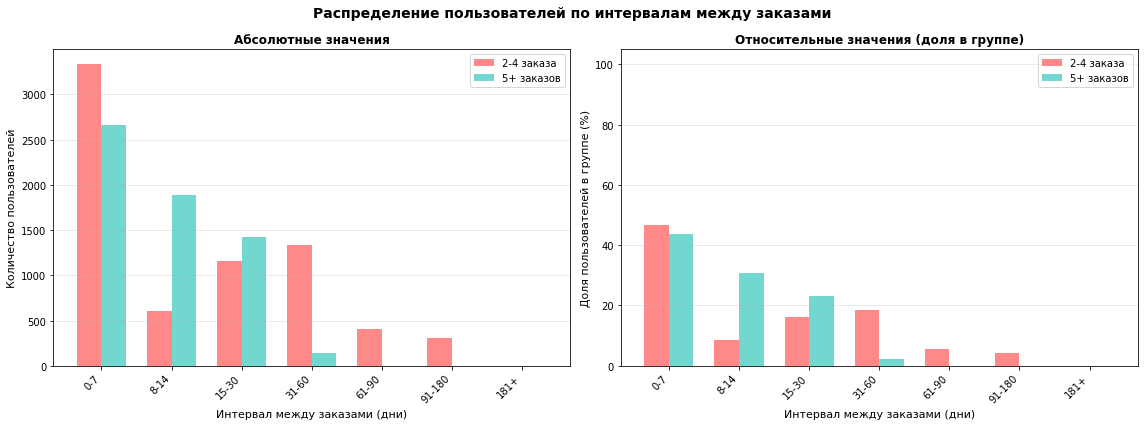

In [101]:
# Создаем фигуру с двумя подграфиками
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Распределение пользователей по интервалам между заказами', fontsize=14, fontweight='bold')

# Абсолютные значения
x = np.arange(len(labels))
width = 0.35

bars1 = ax1.bar(x - width/2, interval_distribution['Кол-во (2-4 заказа)'], 
               width, label='2-4 заказа', color='#FF6B6B', alpha=0.8)
bars2 = ax1.bar(x + width/2, interval_distribution['Кол-во (5+ заказов)'], 
               width, label='5+ заказов', color='#4ECDC4', alpha=0.8)

ax1.set_title('Абсолютные значения', fontsize=12, fontweight='bold')
ax1.set_xlabel('Интервал между заказами (дни)', fontsize=11)
ax1.set_ylabel('Количество пользователей', fontsize=11)
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)


# Относительные значения
bars3 = ax2.bar(x - width/2, interval_distribution['доля % (2-4 заказа)'], 
               width, label='2-4 заказа', color='#FF6B6B', alpha=0.8)
bars4 = ax2.bar(x + width/2, interval_distribution['доля % (5+ заказов)'], 
               width, label='5+ заказов', color='#4ECDC4', alpha=0.8)

ax2.set_title('Относительные значения (доля в группе)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Интервал между заказами (дни)', fontsize=11)
ax2.set_ylabel('Доля пользователей в группе (%)', fontsize=11)
ax2.set_xticks(x)
ax2.set_xticklabels(labels, rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([0, 105])  # Чтобы проценты хорошо отображались



plt.tight_layout()
plt.show()


Анализ данных показывает прямую зависимость между средним интервалом между заказами и вероятностью стать постоянным клиентом (5+ заказов). Чем короче интервал, тем выше шансы на удержание: `74%` постоянных клиентов совершают заказы каждые `14` дней или чаще, тогда как среди клиентов с `2-4` заказами таких только `55%`. Критическим порогом является `30` дней - среди клиентов с интервалом `31-60` дней только `2%` становятся постоянными, а при интервалах более `60` дней таких вообще нет. Оптимальный интервал для удержания - `8-14` дней, где доля постоянных клиентов максимальна (`30,9%` против `8,5%` в группе 2-4 заказа).

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

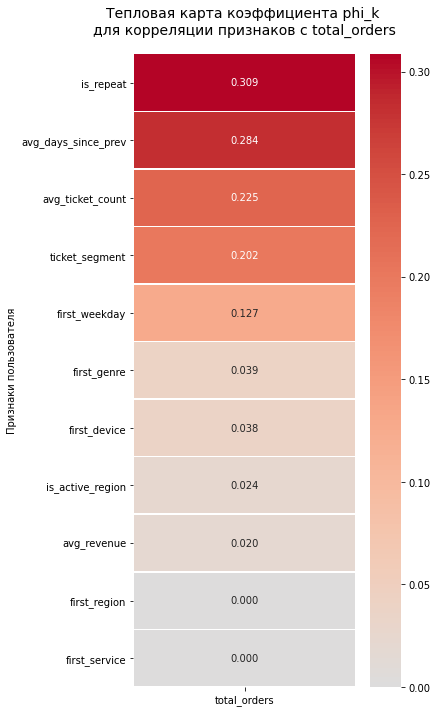

In [102]:
# Исключаем нерелевантные столбцы
exclude_cols = ['user_id', 'first_dt', 'last_dt', 'is_two', 'is_five']
all_features = [col for col in user_profile_clear.columns if col not in exclude_cols]

# Создаем дф с нужными признаками
df = user_profile_clear[all_features].copy()

# Определяем числовые столбцы 
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

correlation_matrix = df.phik_matrix(interval_cols=numeric_cols)

# Выводим результат для переменной total_orders
total_orders_corr = correlation_matrix.loc[correlation_matrix.index != 'total_orders'][['total_orders']].sort_values(by='total_orders', ascending=False)

plt.figure(figsize=(6, 10))
data_heatmap = correlation_matrix.loc[correlation_matrix.index != 'total_orders'][['total_orders']].sort_values(by='total_orders', ascending=False)

sns.heatmap(
    data_heatmap,
    annot=True,  # Отображаем численные значения в ячейках карты
    fmt='.3f',   # Форматируем значения корреляции: три знака после точки
    cmap='coolwarm',  # Устанавливаем цветовую гамму
    linewidths=0.5,   # Форматируем линию между ячейками карты
    cbar=True,        # Включаем цветовую шкалу
    center=0          # Центрируем цветовую шкалу на 0
)

# Добавляем заголовок и подпись по оси Х
plt.title('Тепловая карта коэффициента phi_k \nдля корреляции признаков с total_orders', fontsize=14, pad=20)
plt.ylabel('Признаки пользователя')

# Выводим график
plt.tight_layout()
plt.show()



In [103]:
total_orders_corr

,total_orders
is_repeat,0.308675
avg_days_since_prev,0.283777
avg_ticket_count,0.225348
ticket_segment,0.202057
first_weekday,0.126965
first_genre,0.039058
first_device,0.038455
is_active_region,0.023548
avg_revenue,0.019541
first_region,0.000000


In [104]:
# Создаем сегменты
user_profile_clear['order_segment'] = pd.cut(
    user_profile_clear['total_orders'],
    bins=[1, 2, 5, float('inf')],
    labels=['1 заказ', '2-4 заказа', '5+ заказов'],
    right=False
)

/tmp/ipykernel_139/2042436818.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_profile_clear['order_segment'] = pd.cut(


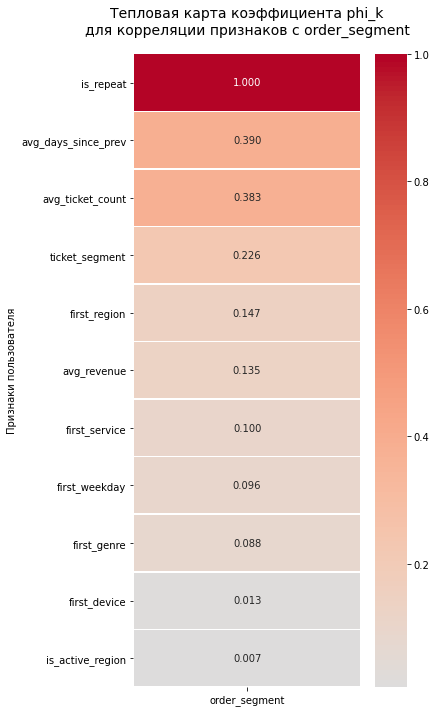

In [105]:
# Исключаем нерелевантные столбцы
exclude_cols = ['user_id', 'first_dt', 'last_dt', 'is_two', 'is_five', 'total_orders']
all_features = [col for col in user_profile_clear.columns if col not in exclude_cols]

# Создаём df с нужными признаками (включая order_segment)
df = user_profile_clear[all_features].copy()

# Определяем числовые столбцы для interval_cols
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Рассчитываем корреляционную матрицу phi_k
correlation_matrix = df.phik_matrix(interval_cols=numeric_cols)

# Выводим результат для переменной order_segment
order_segment_corr = correlation_matrix.loc[
    correlation_matrix.index != 'order_segment'
][['order_segment']].sort_values(by='order_segment', ascending=False)

# Тепловая карта
plt.figure(figsize=(6, 10))
data_heatmap = correlation_matrix.loc[
    correlation_matrix.index != 'order_segment'
][['order_segment']].sort_values(by='order_segment', ascending=False)

sns.heatmap(
    data_heatmap,
    annot=True,
    fmt='.3f',
    cmap='coolwarm',
    linewidths=0.5,
    cbar=True,
    center=0
)

plt.title('Тепловая карта коэффициента phi_k\nдля корреляции признаков с order_segment',
          fontsize=14, pad=20)
plt.ylabel('Признаки пользователя')
plt.tight_layout()
plt.show()

In [106]:
order_segment_corr

,order_segment
is_repeat,1.000000
avg_days_since_prev,0.390321
avg_ticket_count,0.383265
ticket_segment,0.226045
first_region,0.146820
avg_revenue,0.134592
first_service,0.100335
first_weekday,0.095881
first_genre,0.088074
first_device,0.013207


Переход от числового `total_orders` к `категориальным сегментам` увеличил корреляцию phi_k для всех значимых признаков: наиболее сильно выросли `avg_days_since_prev` с `0.28` до `0.39` и `avg_ticket_count` с `0.23` до `0.38`, а `avg_revenue`, `first_region` и `first_service`, ранее имевшие `нулевую` или `очень слабую` связь, теперь показывают умеренную корреляцию. Это подтверждает, что сегментация сглаживает влияние сильной скошенности распределения заказов и позволяет выявить нелинейные зависимости.

Умеренная корреляция ticket_segment и first_region может указывать на то, что принадлежность к определённым категориям по объёму покупок и географическим точкам входа создаёт предпосылки для более частых визитов, но не является определяющей. Слабые связи с avg_revenue, first_service, first_weekday и first_genre говорят о том, что эти факторы сами по себе не влияют на число заказов — они могут быть важны для привлечения, но не для удержания. Практически нулевая корреляция с first_device и is_active_region подтверждает, что тип первого устройства и принадлежность к активному региону не имеют значения для повторных покупок. Таким образом, для повышения возвращаемости ключевыми рычагами являются сокращение интервала между заказами (например, через программы лояльности, напоминания) и увеличение среднего числа билетов (групповые предложения, скидки за компанию), в то время как остальные признаки можно рассматривать как второстепенные для стратегий удержания.

### 5. Общий вывод и рекомендации <a name="chapter-5"></a>

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

**Информация о данных**:

В ходе анализа использовался датасет из `290 611` транзакций, содержащий информацию о покупках билетов на Яндекс Афише.  Пропущенные значения обнаружены только в столбце days_since_prev (7,55%), что соответствует ожиданиям — эти значения характеризуют пользователей с единственной покупкой. Типы данных были скорректированы, даты приведены к единому формату, числовые данные оптимизированы для экономии памяти (освобождено более 10 МБ).

Категориальные данные проанализированы и нормализованы: значения приведены к snake_case, проверены на наличие обозначений пропусков. Обнаружена категория "другое" в event_type_main, что может свидетельствовать либо об исходных пропусках, либо о стратегии агрегации редких категорий.

Ключевые метрики — выручка (revenue_rub) и количество билетов (tickets_count) обработаны аномалии: удалены 381 отрицательный заказ (0,13% данных) и отфильтрованы выбросы по 99 перцентилю (2,825 записей). В результате:

Распределение revenue_rub стало более сбалансированным: средний чек снизился с 555.57 до 517.38 руб, стандартное отклонение уменьшилось с 875.50 до 509.35 руб, максимум сократился с 81,174.54 до 2,627 руб.

Данные tickets_count содержат незначительно кол-во выбросов которые относятся к разовым покупкам билетов на группу людей. Было принято решение оставить данные в выборке.

Все транзакции в тенге были переведены в рубли по кросс-курсу: revenue_rub = revenue / 100 × курс_тенге_к_рублю на дату покупки. Это позволило привести все финансовые показатели к единой валюте.

Общий объем данных сократился незначительно: из 290,611 строк удалено 3,206 (1.01%). Очищенный датасет сохранил репрезентативность (98.99% исходных данных)

**Основные результаты анализа:**

Профиль пользователя содержит данные 21 838 уникальных пользователей. У всех пользователей есть данные о первом и последнем заказе, регионе, сервисе и жанре первого мероприятия. Среднее время между заказами доступно только для 13 505 пользователей 62%, что означает, что 38% пользователей совершили лишь один заказ.

Количество пользователей которые совершиил покупку 2-а и более раза составило 61%, а 5 и более 29%. Это говорит о том, что типовой клиент имеет высокую долю возвращаемости в сервис.

После фильтрации данных по 99-му перцентилю (≤152 заказа) распределение количества заказов на пользователя стало значительно более сбалансированным: среднее значение снизилось с 13.2 до 6.5 заказов, приблизившись к медиане (2 заказа), а стандартное отклонение уменьшилось с 121.6 до 14.3, что свидетельствует о существенном снижении вариативности. В ходе фильтрации было удалено 216 строк (менее 1% датафрейма)

Итоговый профиль пользователей составил 21 622 уникальных клиента с полной информацией о первом заказе, регионах, жанрах и поведенческих метриках.

Распределение по числу заказов: 
- 38% пользователей имеют только 1 заказ,
- 61% – 2+ заказа,
- 28% – 5+ заказов.

Медиана заказов – 2, среднее после очистки – 6,5 (против исходных 13,2), что свидетельствует о высокой доле повторных покупок, но с сильной правосторонней асимметрией.

Доля повторных заказов (retention): в среднем ~61%, варьируется в зависимости от канала привлечения, жанра, дня недели.

Типичный первый заказ: мобильное устройство (82,9%), концертный жанр (42,5%), Каменевский регион (32%), оператор «билеты_без_проблем» (22,2%).

Статистически значимые связи (phi_k, тесты гипотез):

- Жанр первого мероприятия: пользователи, начавшие со спорта, возвращаются значимо чаще, чем начавшие с концертов (66,2% vs 60,3%, p < 0,001, odds ratio = 1,29). Гипотеза подтверждена.

- День недели первой покупки: максимум повторных заказов у клиентов, пришедших в четверг (66,0%), минимум – в пятницу (57,1%). Разрыв в 8,9 п.п. указывает на влияние дня первого контакта на лояльность.

- Средний интервал между заказами (avg_days_since_prev): сильная отрицательная корреляция с сегментом заказов (phi_k = 0,39). Чем короче интервал, тем выше вероятность перехода в сегмент 5+ заказов. Критический порог – 30 дней: при интервалах более 30 дней доля постоянных клиентов падает до 2%, при >60 дней – нулевая. Оптимальный интервал удержания – 8–14 дней.

- Среднее количество билетов (avg_ticket_count): сильная положительная корреляция (phi_k = 0,38). Постоянные клиенты покупают в среднем больше билетов за раз (медиана ≈ 3), что отражает групповые/семейные походы.

- Сегмент билетов, средний чек, регион, первый сервис: после перехода от числового total_orders к категориальному order_segment корреляции выросли до умеренных (0,13–0,23). Сегментация позволила выявить нелинейные связи, ранее скрытые из-за скошенности распределения заказов.

Региональная активность: гипотеза о том, что в регионах с наибольшим числом пользователей доля повторных заказов выше, не подтвердилась (p = 0,35). Уровень удержания равномерен по географии (≈61%), что говорит о зрелости сервиса во всех регионах.

**Рекомендации для бизнеса:**

- Сместить маркетинговый бюджет в сторону спортивных мероприятий: аудитория, привлечённая через спорт, демонстрирует наилучшие показатели LTV.

- Для концертной аудитории внедрить механики повышения повторных продаж: скидка на второй заказ, персонализированные push-уведомления с анонсами похожих событий, кросс-промо спортивных мероприятий после покупки концерта.

- Наиболее эффективное окно для стимулирования повторной покупки – 8–14 дней после предыдущего заказа. Автоматические напоминания и персональные рекомендации следует запускать именно в этом интервале.

- Усилить активность в середине недели (вторник–четверг), так как пользователи, пришедшие в эти дни, показывают максимальный retention. Добавить динамичекое ценообразование в зависимости от спроса.

Сегмент «1 заказ» (38% пользователей):
- Запустить кампании: скидка 20% на второй заказ, подборка популярных событий в его регионе.
- Использовать push-уведомления с ограничением по времени («Успейте купить со скидкой»).

Сегмент «2–4 заказа» (33%):
- Внедрить программу лояльности: накопительные баллы, ранний доступ к билетам.
- Предлагать «пакетные» предложения (мероприятие + мерч).

Сегмент «5+ заказов» (29%):
- Сформировать премиум-клуб: эксклюзивные мероприятия, персональный менеджер.
- Стимулировать реферальные приглашения (бонусы за приведённых друзей).

### 6. Финализация проекта и публикация в Git <a name="chapter-6"></a>

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**

https://github.com/taysilya/project_module_2